In [1]:
__author__ = "Len Washington III"

from tools import *
from population import *
from data import *
from inmates import Inmates
from causes import Causes
import pandas as pd
import numpy as np
from seaborn import regplot
from scipy.stats import linregress
from matplotlib import pyplot as plt
from PIL import Image
from warnings import filterwarnings
from statsmodels.stats.proportion import proportions_ztest
filterwarnings("ignore")

### Education

In [2]:
def _biggest_race_generator(row:pd.core.series.Series) -> int:
    races = (row["Black Population"], row["Hispanic Population"], row["Native American Population"], row["Asian Population"], row["Pacific Islander Population"], row["White Population"], row["Other Population"])
    return Races.Races.value[races.index(max(races))]

def _second_biggest_race_generator(row:pd.core.series.Series) -> int:
    races = (row["Black Population"], row["Hispanic Population"], row["Native American Population"], row["Asian Population"], row["Pacific Islander Population"], row["White Population"], row["Other Population"])
    races = [i for i in races if i != max(races)]
    return Races.Races.value[races.index(max(races))]

def graduation_rate(file_name:str) -> pd.DataFrame:
    df = pd.read_csv(file_name)
    df["Biggest Race"] = df.apply(_biggest_race_generator, axis=1)
    df["Second Biggest Race"] = df.apply(_second_biggest_race_generator, axis=1)
    return df

races = ("Black", "Hispanic", "Native American", "Asian", "Pacific Islander", "White", "Other")
output_folder = "./outputs/jupyter"
figsize = (12,8)

all_state_data = graduation_rate(add_data_dir("Education/state_data_w_o_us.csv")).set_index("State")
# Enrollment sizes can be found in Education/elsec18_sumtables.csv, sheet_name=19

race_population_data = all_state_data.filter(["State", "Biggest Race", "Second Biggest Race"] + [f"{i} Population" for i in races])
state_education_data = all_state_data.filter(['State', 'State Abbreviation', 'Population 2018', 'Population 2020', 'Population 2021', 'Growth 2021', 'Census 2010', 'Growth Since 2010', 'Percent Of US', 'Density', 'Graduation Rate', 'Instruction Spending Per Pupil', 'Support Spending Per Pupil', 'Total Spending Per Pupil', 'Total Instruction Spending', 'Total Spending', 'Total Support Spending', 'Black Population', 'Hispanic Population', 'Native American Population', 'Asian Population', 'Pacific Islander Population', 'White Population', 'Other Population'])
graduation_spending_df = Spending(add_data_dir("Education/edu_spending.csv")).df.merge(Spending(add_data_dir("Education/21gradrates.csv")).df, how='left', left_index=True, right_index=True)

state_police_shooting_data = pd.read_excel(add_data_dir("Police/MPVDatasetDownload.xlsx"), sheet_name="2013-2020 Killings by State")
police_killings_department_data = pd.read_excel(add_data_dir("Police/MPVDatasetDownload.xlsx"), sheet_name="2013-2020 Killings by PD")
race_population_data.head()

,Biggest Race,Second Biggest Race,Black Population,Hispanic Population,Native American Population,Asian Population,Pacific Islander Population,White Population,Other Population
State,,,,,,,,,
Alabama,White,Black,1285737,203146,23243,63936,1521,3196730,90367
Alaska,White,Native American,22817,51186,103506,45617,8544,450754,56092
Arizona,White,Hispanic,286614,2163312,271946,222477,12523,3825886,163927
Arkansas,White,Black,458536,219052,17342,43441,7877,2173849,70574
California,Hispanic,Pacific Islander,2164519,15221577,138427,5525439,138911,14695836,1264051


##### There are only 4 states that aren't majority white, California, DC, Hawaii, New Mexico, which is why we'll be examining the second biggest race for plotting

In [3]:
race_population_data[race_population_data["Biggest Race"] != "White"].head()

,Biggest Race,Second Biggest Race,Black Population,Hispanic Population,Native American Population,Asian Population,Pacific Islander Population,White Population,Other Population
State,,,,,,,,,
California,Hispanic,Pacific Islander,2164519,15221577,138427,5525439,138911,14695836,1264051
District of Columbia,Black,Pacific Islander,315281,74776,1314,26278,280,248057,18512
Hawaii,Asian,Pacific Islander,24472,147962,1877,522731,132583,314536,277868
New Mexico,Hispanic,Pacific Islander,38016,1015751,183408,29571,1046,788308,36334


In [4]:
x = 0
def US_grad_rate(row):
    global x
    if row.name != "United States":
        x += row["High School Graduation Rate"]

graduation_spending_df.apply(US_grad_rate, axis=1)
graduation_spending_df["High School Graduation Rate"]["United States"] = round(x / 51, 1)

In [5]:
def state_education_spending(df:pd.DataFrame, x:str, scale=1, save=""):
    plt.figure(figsize=figsize)
    ax = regplot(x=df[x].apply(lambda x: x / scale), y=df["Graduation Rate"])
    ax.set_title(f"{x} vs Graduation Rate by State")
    scale_label = f" (per ${scale:,})" if scale != 1 else ""        
    ax.set_xlabel(f"{x}{scale_label if scale != 1 else ''}")
    ax.set_ylabel("Graduation Rate (%)")
    if save:
        ax.get_figure().savefig(f"{output_folder}/education/{save}.png")

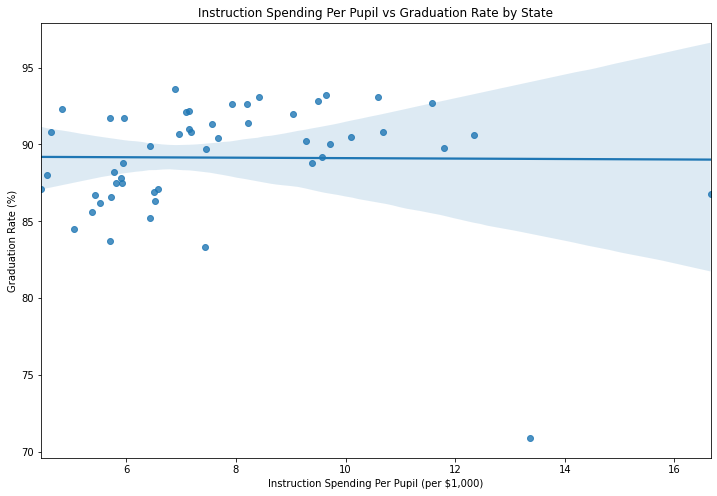

In [6]:
state_education_spending(state_education_data, "Instruction Spending Per Pupil", scale=1_000, save="instruction_spending_vs_grad_rate_original.png")

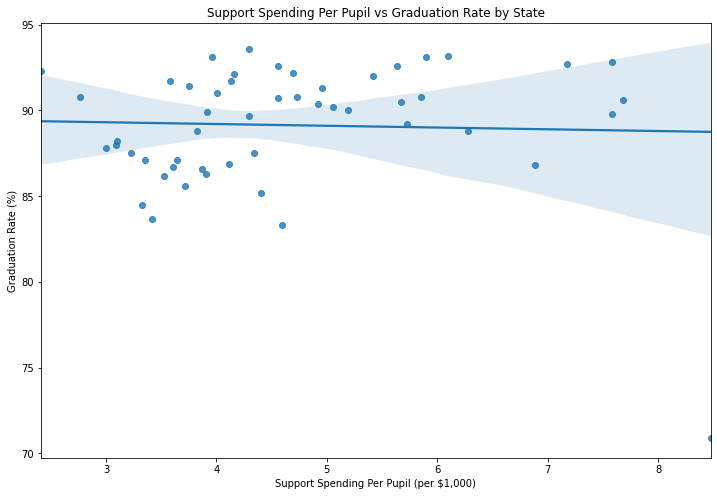

In [7]:
state_education_spending(state_education_data, "Support Spending Per Pupil", scale=1_000, save="support_spending_vs_grad_rate_original.png")

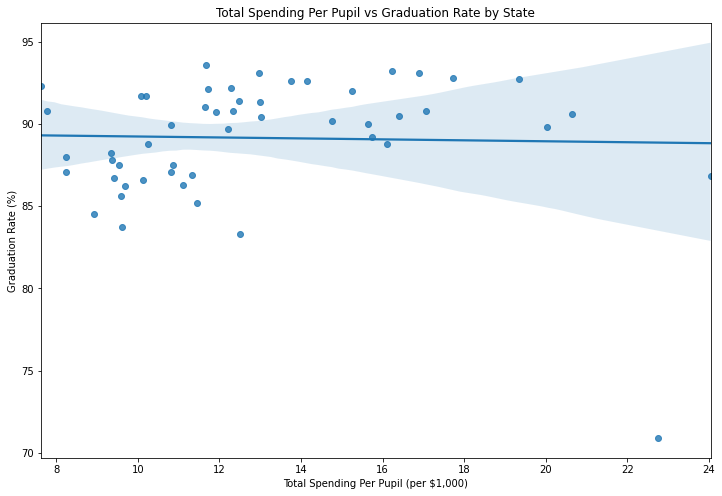

In [8]:
state_education_spending(state_education_data, "Total Spending Per Pupil", scale=1_000)

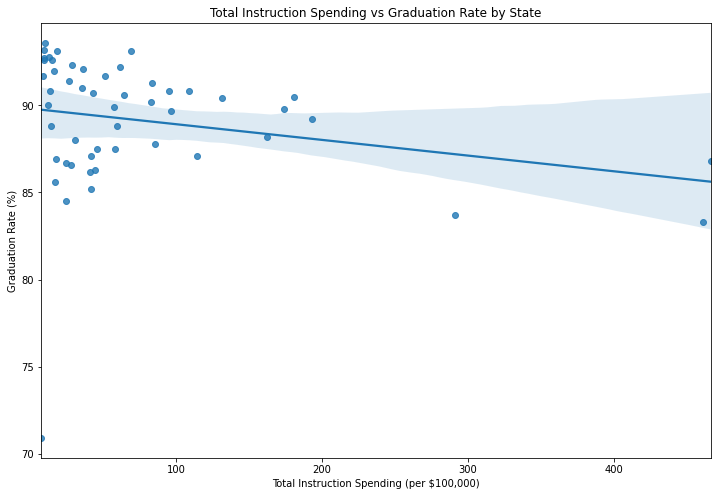

In [9]:
state_education_spending(state_education_data, "Total Instruction Spending", scale=100_000, save="total_instruction_spending_vs_grad_rate_original.png")

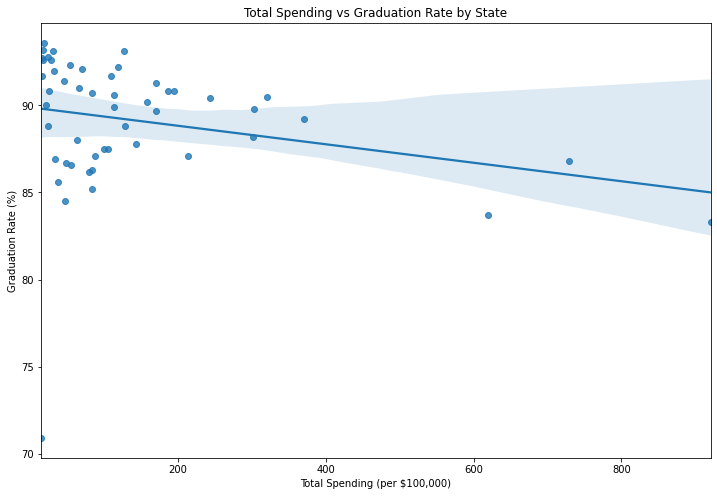

In [10]:
state_education_spending(state_education_data, "Total Spending", scale=100_000, save="total_spending_vs_grad_rate_original.png")

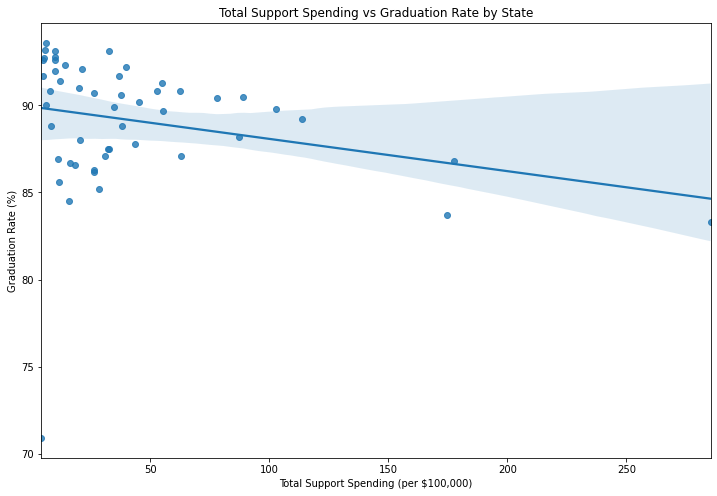

In [11]:
state_education_spending(state_education_data, "Total Support Spending", scale=100_000, save="total_support_spending_vs_grad_rate_original.png") #Graph graduation rate times population vs spending

#### Total Population vs Spending

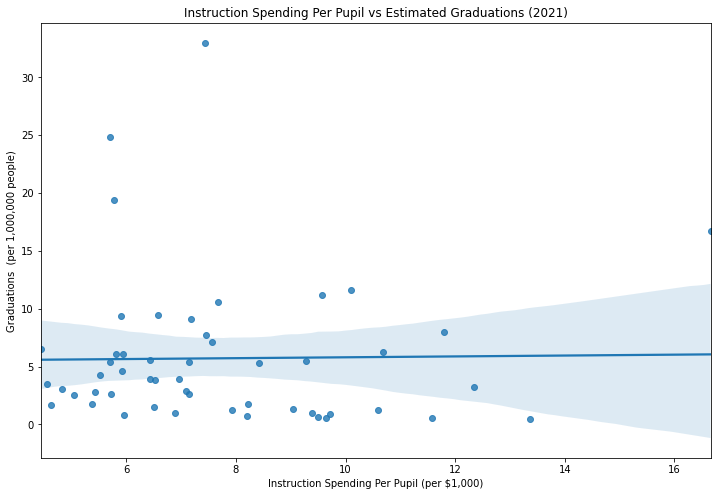

In [12]:
def graph_total_population(df:pd.DataFrame, x:str, x_scale=1, y_scale=1_000_000, year=2021, save=""):
    plt.figure(figsize=figsize)
    ax = regplot(x=df[x].apply(lambda value: value / x_scale), y=(df["Graduation Rate"] / 100) * df[f"Population {year}"] / y_scale)
    ax.set_title(f"{x} vs Estimated Graduations ({year})")
    x_scale_label = f" (per ${x_scale:,})" if x_scale != 1 else ""
    y_scale_label = f" (per {y_scale:,} people)" if y_scale != 1 else ""

    ax.set_xlabel(f"{x}{x_scale_label if x_scale != 1 else ''}")
    ax.set_ylabel(f"Graduations {y_scale_label if y_scale != 1 else ''}")
    if save:
        ax.get_figure().save(f"{output_folder}/education/{save}.png")
    
graph_total_population(state_education_data, "Instruction Spending Per Pupil" , x_scale=1_000)

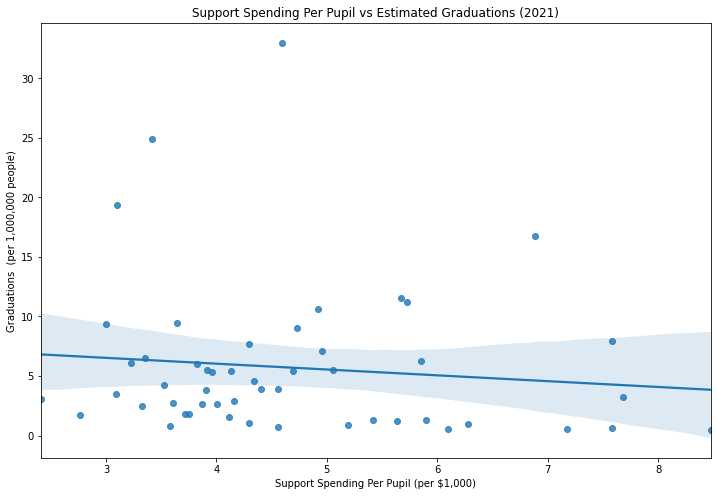

In [13]:
graph_total_population(state_education_data, "Support Spending Per Pupil", x_scale=1_000)

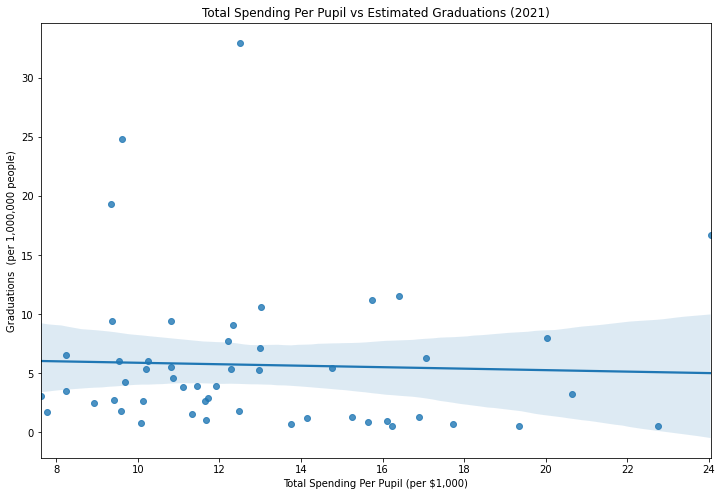

In [14]:
graph_total_population(state_education_data, "Total Spending Per Pupil", x_scale=1_000)

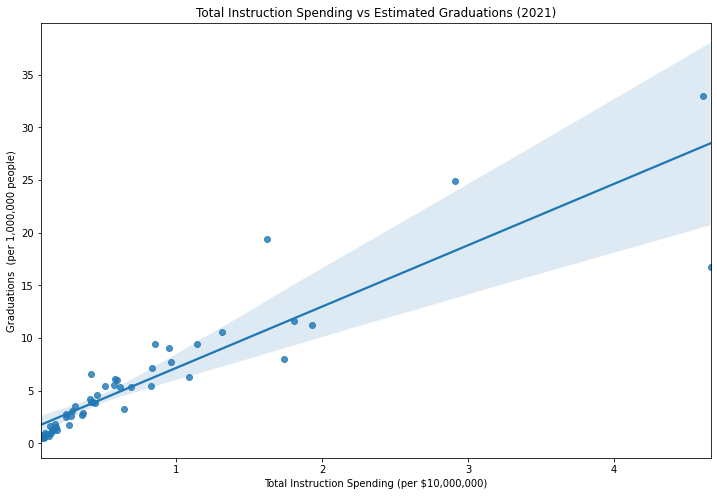

In [15]:
graph_total_population(state_education_data, "Total Instruction Spending", x_scale=10_000_000)

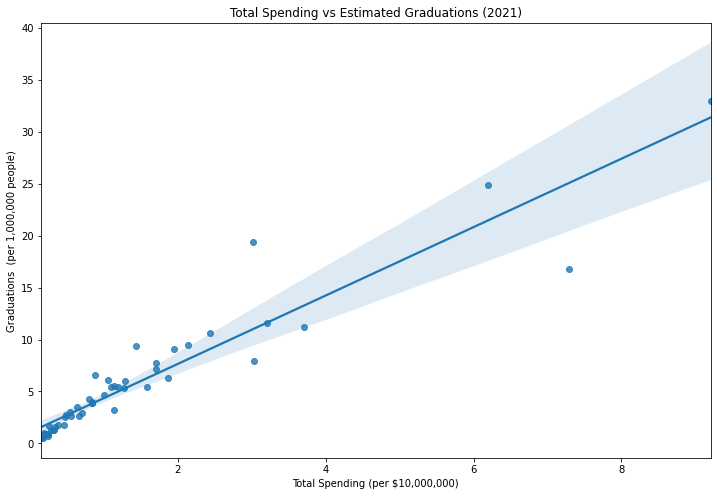

In [16]:
graph_total_population(state_education_data, "Total Spending", x_scale=10_000_000)

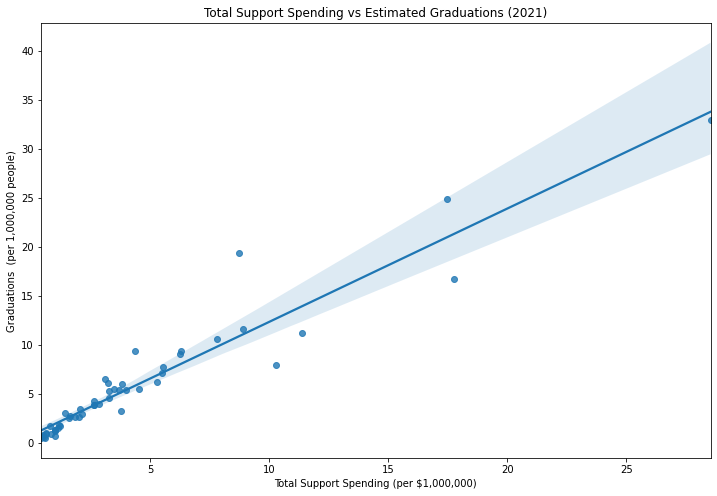

In [17]:
graph_total_population(state_education_data, "Total Support Spending", x_scale=1_000_000)

#### Spending vs Graduation Rates

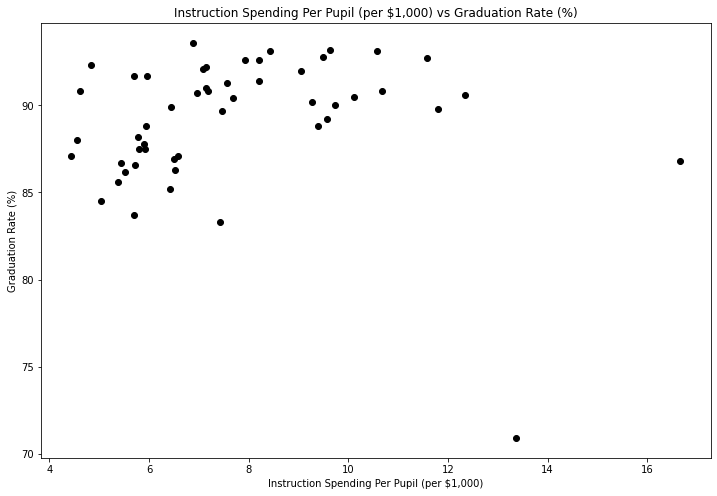

In [18]:
def spending_graph(df:pd.DataFrame, x:str, y:str, special="", color1="#000000", color2="#ff0000", x_scale=1, save="", transparent=True):
    """
        Creates a scatter plot from the provided dataframe.

        Parameters
        ----------
        df : pd.DataFrame
            This is the DataFrame that the function will draw values from.
        x : str
            This label of the series in the dataframe that should be used as the independent variable.
        y : str
            This label of the series in the dataframe that should be used as the dependent variable.
        special : str, optional
            This will plot a specific data point found in both the independent and dependent series and plot it in a different color.
        color1 : str, optional
            The default color of all points plotted. This will not apply to the special data point if one is provided. Default is black.
        color2 : str, optional
            The default color of the special data point. Default is red.
        x_scale : float, optional
            A scale that will be applied to every data point for the independent, x, variables.
        save : float, optional
            The file location where the plot should be saved. Will be saved to the directory that is saved in outputDirectory. Default does not save.
        transparent : bool, optional
            If the graph background should be transparent when saving. Default is yes.

        Returns
        -------
        Matplotlib.pyplot

        Examples
        --------
        >>> df[y]
            Row1        1000.0
            Row2        2500.0
            Row3       15000.0
        >>> x_scale = 1_000
        >>> df[y]
            Row1        1.0000
            Row2        2.5000
            Row3       15.0000
        """
    df = df.drop("United States")
    plt.figure(figsize=figsize)
    plt.scatter(df[x].apply(lambda x: x/x_scale), df[y], c=color1)
    if special:
        plt.scatter(df[x][special]/x_scale, df[y][special], c=color2, label=f"{special} {x} ($)")
    x_scale_label = f"(per ${x_scale:,})" if x_scale != 1 else "($)"        
    plt.xlabel(f"{x} {x_scale_label}")
    plt.ylabel("Graduation Rate (%)")
    plt.title(f"{x} {x_scale_label} vs Graduation Rate (%)")
    if save:
        plt.savefig(f"{output_folder}/education/{save}", transparent=transparent)
    return plt

special="Illinois"
spending_graph(graduation_spending_df, "Instruction Spending Per Pupil", "High School Graduation Rate", x_scale=1000).show()

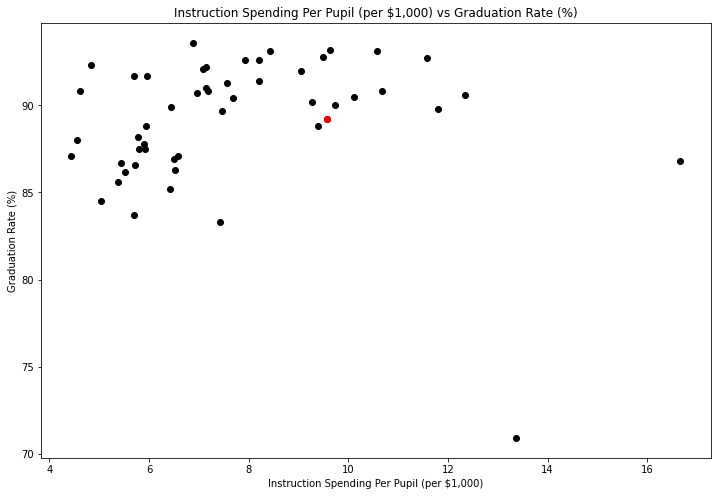

In [19]:
spending_graph(graduation_spending_df, "Instruction Spending Per Pupil", "High School Graduation Rate", special=special, x_scale=1000, save="instruction_spending_vs_grad_rate.png").show()

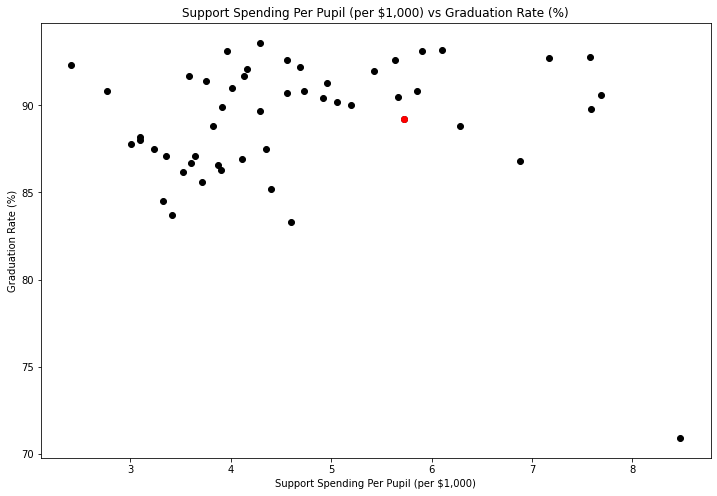

In [20]:
spending_graph(graduation_spending_df, "Support Spending Per Pupil", "High School Graduation Rate", special=special, x_scale=1000, save="support_spending_per_student_vs_grad_rate.png").show()

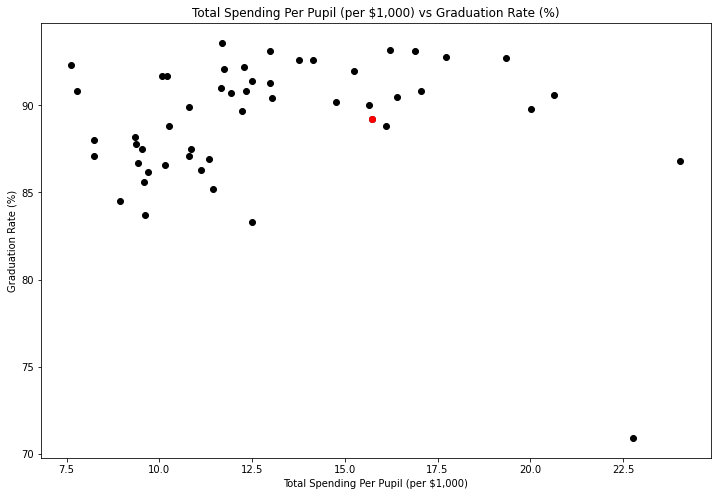

In [21]:
spending_graph(graduation_spending_df, "Total Spending Per Pupil", "High School Graduation Rate", special=special, x_scale=1000, save="total_spending_per_pupil_vs_grad_rate.png").show()

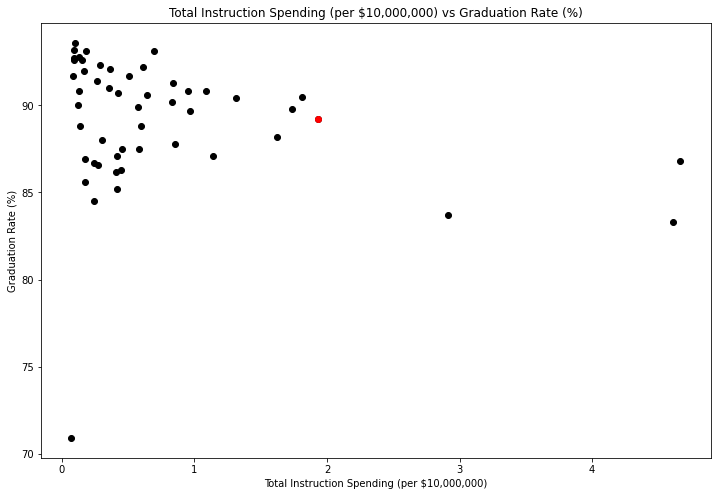

In [22]:
spending_graph(graduation_spending_df, "Total Instruction Spending", "High School Graduation Rate", special=special, x_scale=10_000_000, save="total_instruction_spending.png").show()

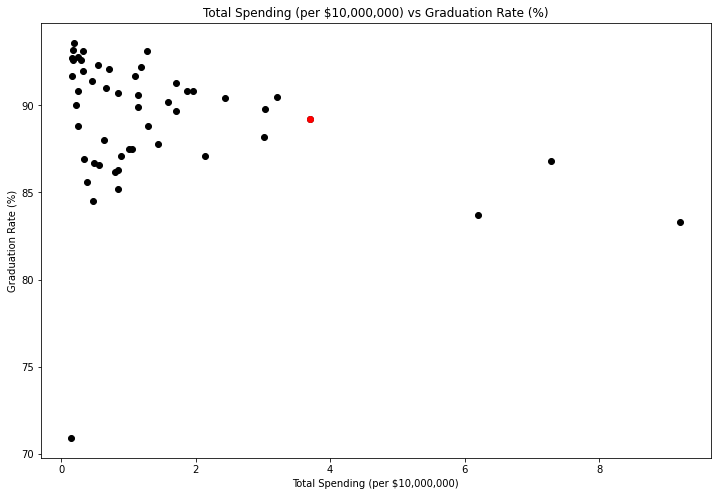

In [23]:
spending_graph(graduation_spending_df, "Total Spending", "High School Graduation Rate", special=special, x_scale=10_000_000, save="total_spending_vs_grad_rate.png").show()

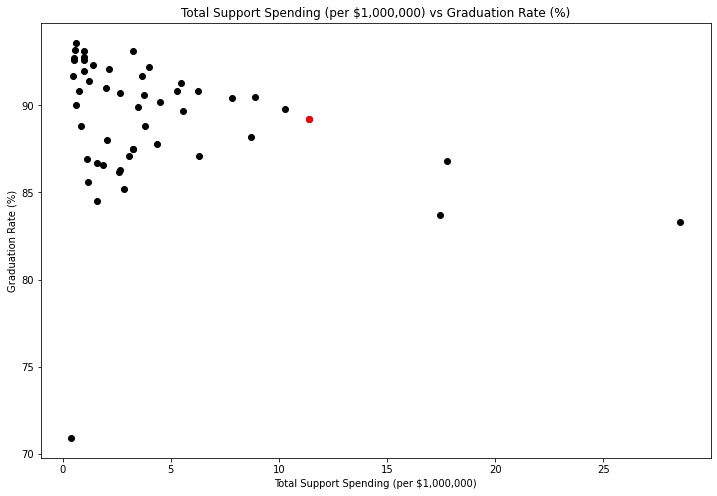

In [24]:
spending_graph(graduation_spending_df, "Total Support Spending", "High School Graduation Rate", special=special, x_scale=1_000_000, save="total_support_spending_vs_grad_rate.png").show()

#### Spending w/ Lines

In [25]:
def spending_with_lines(df:pd.DataFrame, x:str, y:str, special="", color1="#000000", color2="#ff0000", x_scale=1, save="", transparent=True, remove=()) -> LinearEquation:
    df.drop("United States")
    start = int(df[x].min()) - 1
    end = int(df[x].max()) + 1
    step = int((end-start)/6)
    plt.figure(figsize=figsize)
    spending_graph(df, x, y, special=special, color1=color1, color2=color2, x_scale=x_scale)
    y_line = LinearEquation.removal(df, x, y, remove=remove)
    x = np.linspace(start, end, step)
    y = y_line.getNpLinspace(start, end, step)
    x /= x_scale
    plt.plot(x, y, label="Relation of Funding to Graduation %")#label=str(y_line.rounded_y_intercept(5)))
    plt.legend(loc="lower left", fancybox=True, framealpha=0)
    if save:
        plt.savefig(f"{output_folder}/education/{save}", transparent=transparent)
    plt.show()
    return y_line

<Figure size 864x576 with 0 Axes>

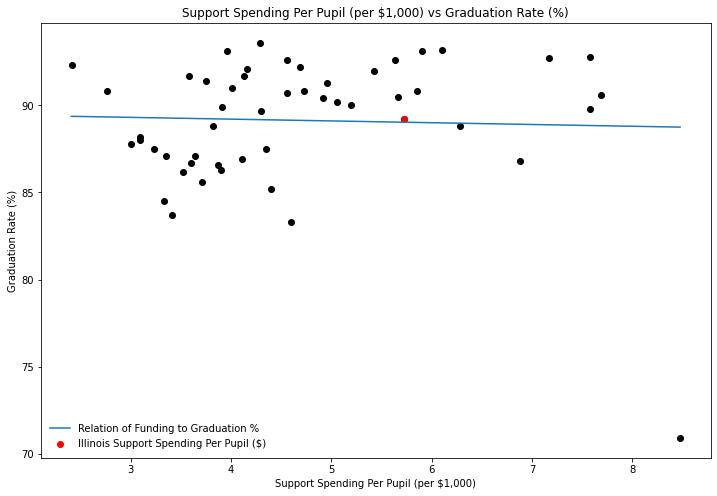

-0.00010222402608023601x + 89.6188357440409

In [26]:
spending_with_lines(graduation_spending_df, "Support Spending Per Pupil", "High School Graduation Rate", x_scale=1000, special=special, save="support_spending_per_student_vs_grad_rate_w_line.png")

<Figure size 864x576 with 0 Axes>

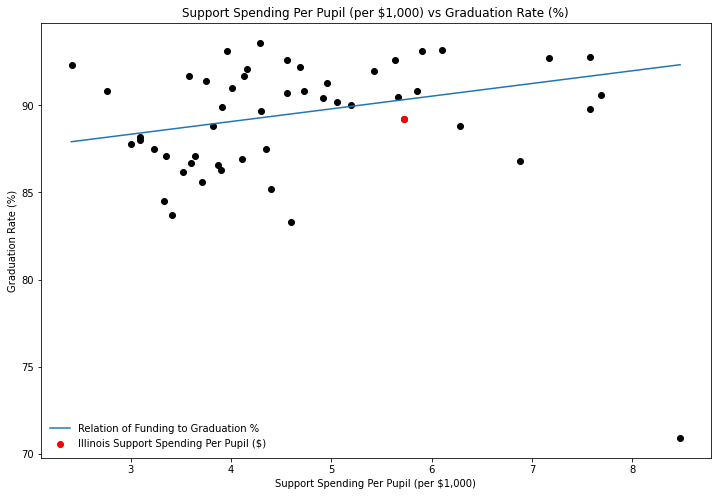

0.000728816760463765x + 86.15704226417232

In [27]:
spending_with_lines(graduation_spending_df, "Support Spending Per Pupil", "High School Graduation Rate", x_scale=1000, special=special, save="support_spending_per_student_vs_grad_rate_w_line_and_dc_removed.png", remove=["District of Columbia"])

<Figure size 864x576 with 0 Axes>

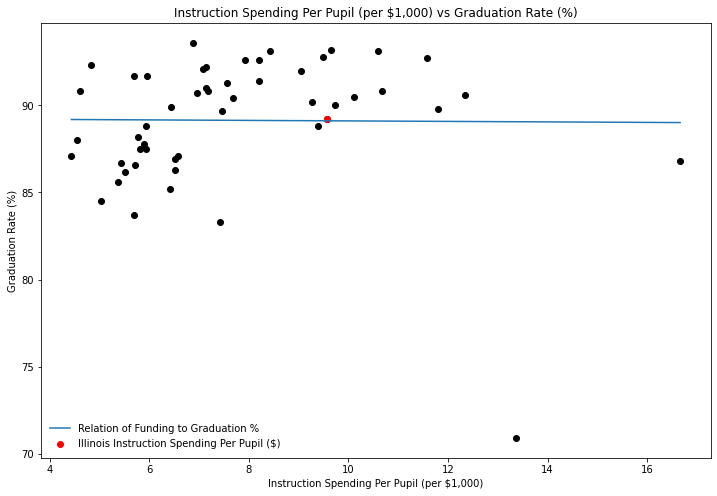

-1.43893622349908e-05x + 89.25323928987794

In [28]:
spending_with_lines(graduation_spending_df, "Instruction Spending Per Pupil", "High School Graduation Rate", x_scale=1000, special=special, save="instruction_spending_vs_grad_rate_w_line.png")

<Figure size 864x576 with 0 Axes>

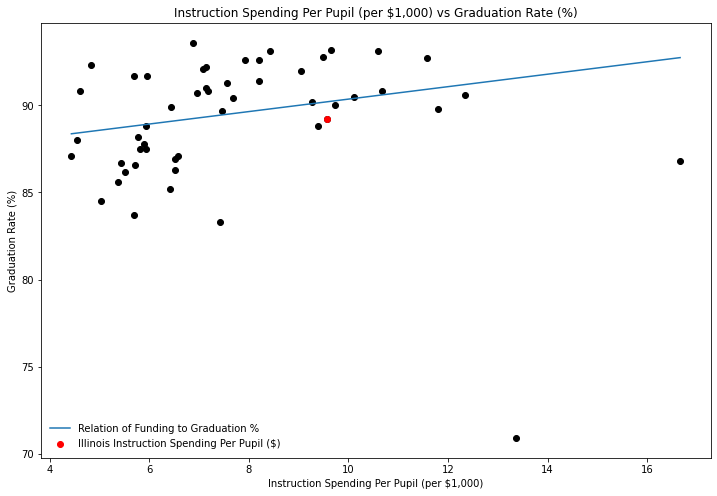

0.0003577358146435504x + 86.78178731735665

In [29]:
spending_with_lines(graduation_spending_df, "Instruction Spending Per Pupil", "High School Graduation Rate", x_scale=1000, special=special, save="instruction_spending_vs_grad_rate_w_line_w-o_DC.png", remove=["District of Columbia"])

<Figure size 864x576 with 0 Axes>

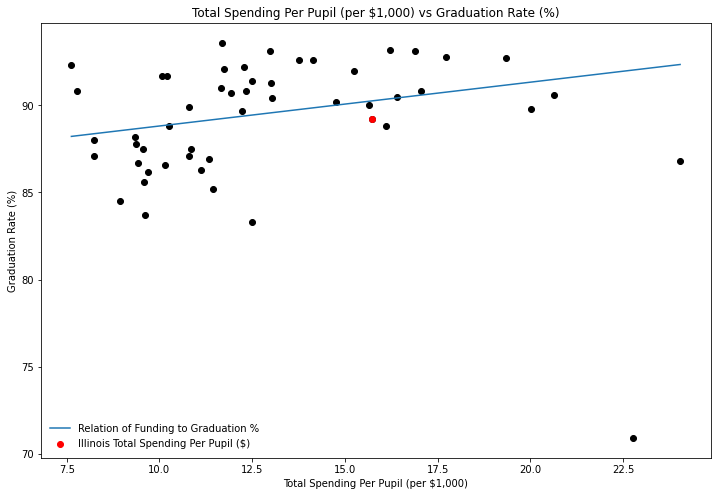

0.00025151900483898887x + 86.30130413111961

In [30]:
spending_with_lines(graduation_spending_df, "Total Spending Per Pupil", "High School Graduation Rate", x_scale=1000, special=special, save="total_spending_per_pupil_vs_grad_rate_w_line.png", remove=["District of Columbia"])

##### You can try running these 3 cells, but they gave me a MemoryError

<Figure size 864x576 with 0 Axes>

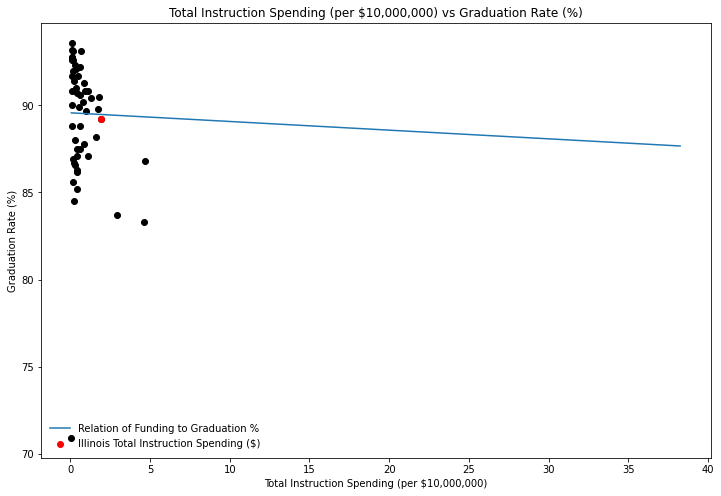

-4.9834821474609415e-09x + 89.57467933979568

In [31]:
spending_with_lines(graduation_spending_df, "Total Instruction Spending", "High School Graduation Rate", x_scale=10_000_000, special=special, save="total_instruction_spending_w_line.png", remove=["District of Columbia"])

<Figure size 864x576 with 0 Axes>

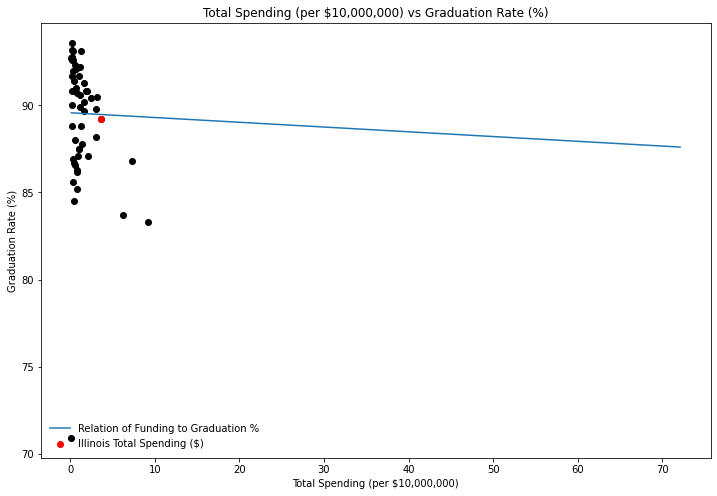

-2.7329087311255246e-09x + 89.57718496009457

In [32]:
spending_with_lines(graduation_spending_df, "Total Spending", "High School Graduation Rate", x_scale=10_000_000, special=special, save="total_spending_vs_grad_rate_w_line.png", remove=["District of Columbia"])

<Figure size 864x576 with 0 Axes>

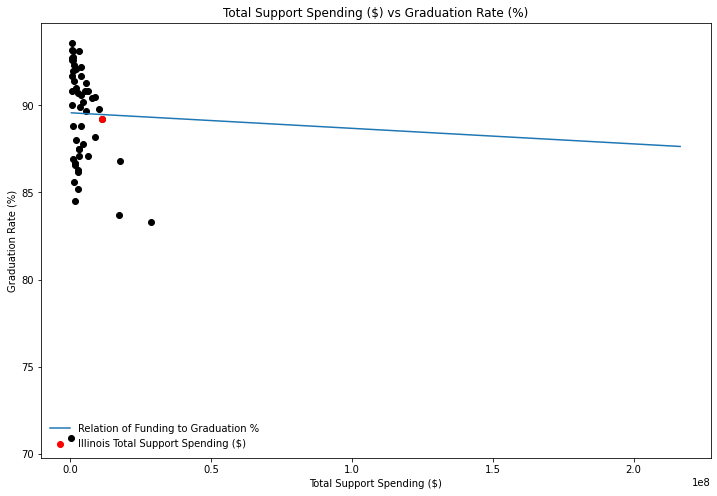

-8.93314269142157e-09x + 89.57578431339526

In [33]:
spending_with_lines(graduation_spending_df, "Total Support Spending", "High School Graduation Rate", special=special, save="total_support_spending_vs_grad_rate_w_line.png", remove=["District of Columbia"])

#### Spending Lines w/ Race

In [34]:
def spending_with_lines_and_race(df:pd.DataFrame, x:str, y:str, color:str, special="", x_scale=1, save="", transparent=True, remove=(), loc="lower right", total=False) -> LinearEquation:
    plt.figure(figsize=figsize)
    for extra in remove:
        df = df.drop(extra)
    for state in df.index:
        row = df.loc[state]
        total_scale = 1
        if total:
            total_scale = all_state_data.loc[special]["Population 2018"]
        plt.scatter(row[x]/x_scale, row[y] * total_scale, c=color[state].color)
    if special:
        second_biggest = race_population_data.loc[special]["Second Biggest Race"]
        plt.scatter(df.loc[special][x]/x_scale, df.loc[special][y], c='r', label=f"{special} (Second Majority: {second_biggest})")
    x_scale_label = f"(per ${x_scale:,})" if x_scale != 1 else "($)"

    start = int(df[x].min()) - 1
    end = int(df[x].max()) + 1
    step = int((end-start)/6)
    y_line = LinearEquation(df[x], df[y])
    x_line = np.linspace(start, end, step)
    y = y_line.slope * x_line + y_line.y_intercept
    x_line /= x_scale

    plt.plot(x_line, y, label="Funding to Graduation %")#label=str(y_line.rounded_y_intercept(5)))
    plt.xlabel(f"{x} {x_scale_label}")
    plt.ylabel("Graduation Rate (%)")
    plt.title(f"{x} {x_scale_label} vs Graduation Rate (%)")
    plt.legend(loc=loc, fancybox=True, framealpha=0)

    if save:
        plt.savefig(f"{output_folder}/education/{save}", transparent=transparent)

    plt.show()
    return y_line

##### Big outlier is New York

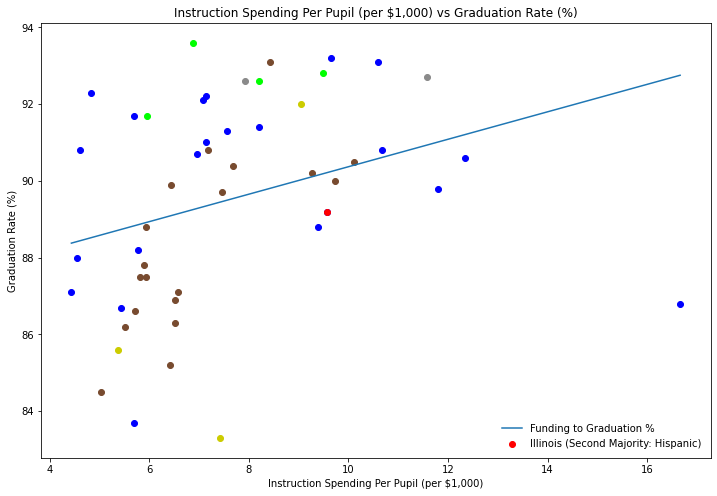

0.0003578133295107149x + 86.78956423236261

In [35]:
spending_with_lines_and_race(graduation_spending_df, "Instruction Spending Per Pupil", "High School Graduation Rate", x_scale=1000, color=race_population_data["Second Biggest Race"], special=special, remove=["United States", "District of Columbia"], save="instruction_spending_vs_grad_rate_w_line_by_race.png")

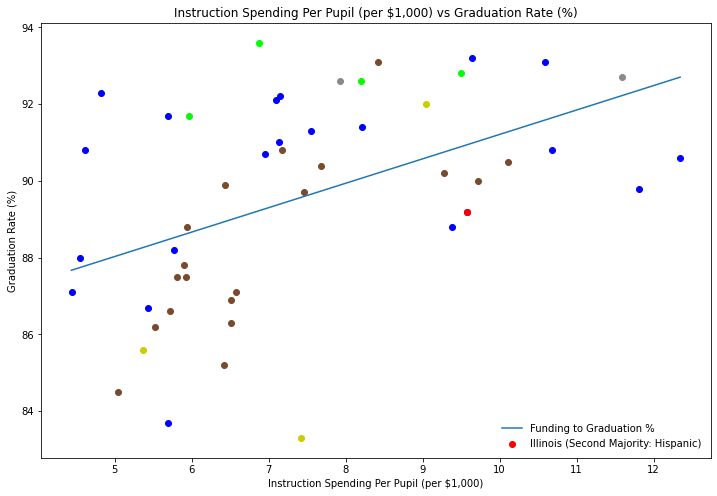

0.0006363742656492579x + 84.84621929051173

In [36]:
spending_with_lines_and_race(graduation_spending_df, "Instruction Spending Per Pupil", "High School Graduation Rate", x_scale=1000, color=race_population_data["Second Biggest Race"], special=special, remove=["United States", "District of Columbia", "New York"], save="instruction_spending_vs_grad_rate_w_line_by_race_w-o_new_york.png")

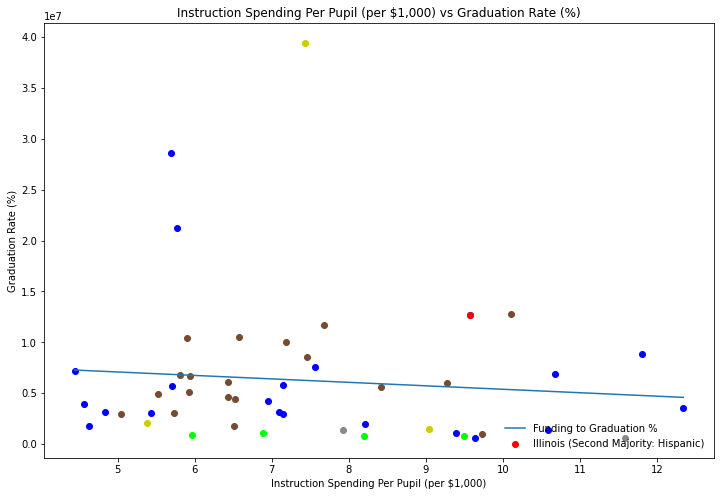

-339.9469392360849x + 8774009.897930566

In [37]:
spending_with_lines_and_race(all_state_data, "Instruction Spending Per Pupil", "Population 2018", x_scale=1000, color=race_population_data["Second Biggest Race"], special=special, remove=["District of Columbia", "New York"], save="instruction_spending_vs_grad_rate_w_line_by_race_w-o_new_york.png")

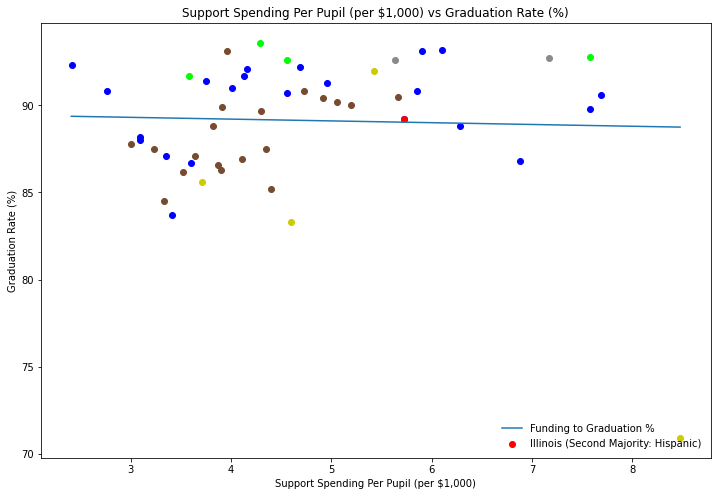

-0.00010235812863471575x + 89.62070097010194

In [38]:
spending_with_lines_and_race(graduation_spending_df, "Support Spending Per Pupil", "High School Graduation Rate", x_scale=1000, color=race_population_data["Second Biggest Race"], special=special, remove=["United States"], save="support_spending_per_student_vs_grad_rate_w_line_by_race.png")

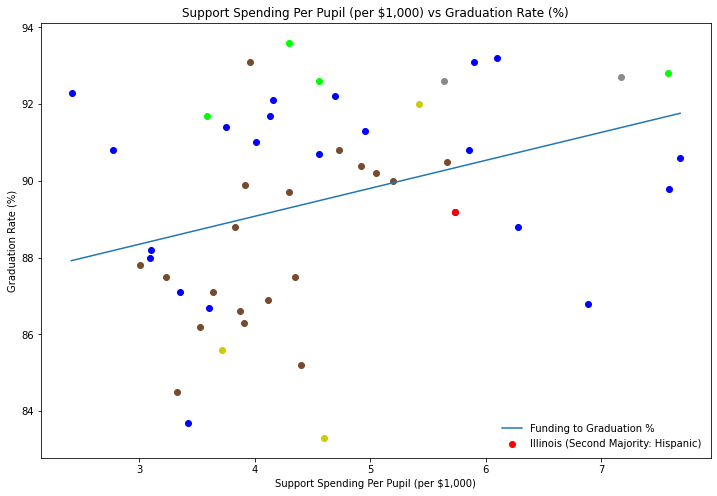

0.0007283326759723645x + 86.1653723533538

In [39]:
spending_with_lines_and_race(graduation_spending_df, "Support Spending Per Pupil", "High School Graduation Rate", x_scale=1000, color=race_population_data["Second Biggest Race"], special=special, remove=["United States", "District of Columbia"], save="support_spending_per_student_vs_grad_rate_w_line_and_dc_removed_by_race.png")

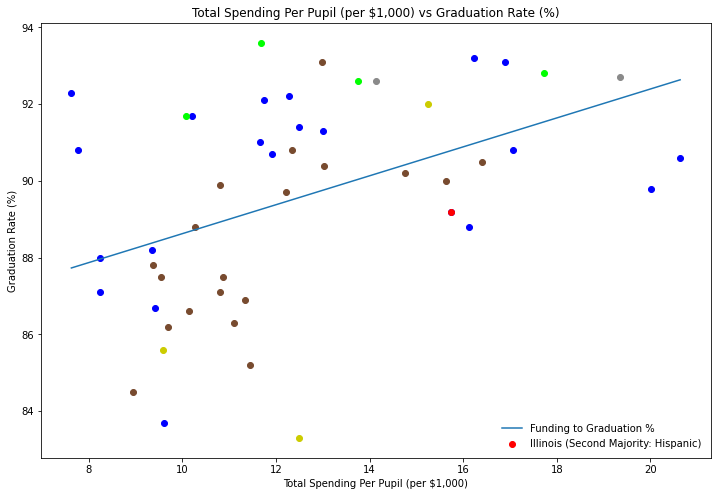

0.00037679001181364425x + 84.85768611120888

In [40]:
spending_with_lines_and_race(graduation_spending_df, "Total Spending Per Pupil", "High School Graduation Rate", x_scale=1000, color=race_population_data["Second Biggest Race"], special=special, remove=["United States", "District of Columbia", "New York"], save="total_spending_per_pupil_vs_grad_rate_w_line_by_race.png")

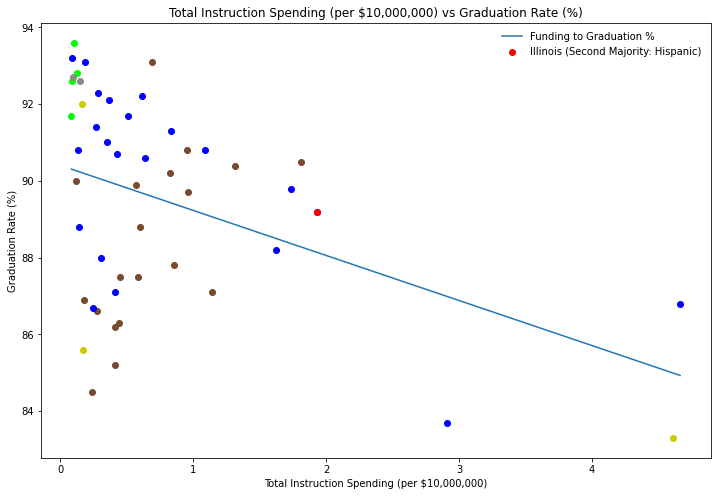

-1.1734170023494252e-07x + 90.4039505222728

In [41]:
spending_with_lines_and_race(graduation_spending_df, "Total Instruction Spending", "High School Graduation Rate", x_scale=10_000_000, color=race_population_data["Second Biggest Race"], save="total_instruction_spending_w_line_by_race.png", special=special, remove=["United States", "District of Columbia"], loc="upper right")

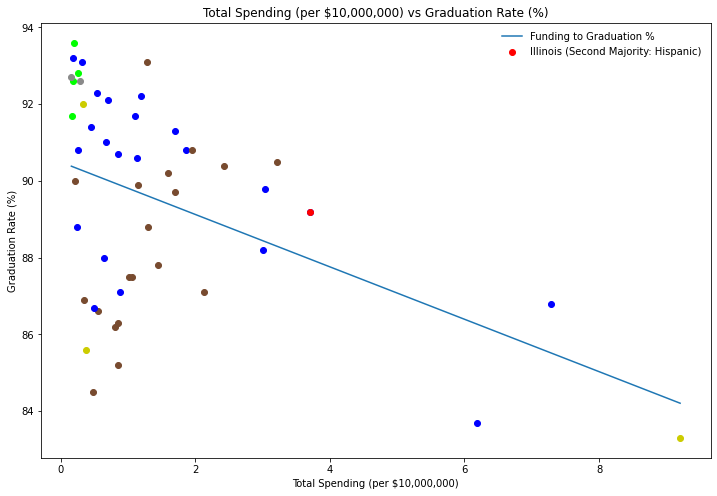

-6.825567321122808e-08x + 90.49011335241437

In [42]:
spending_with_lines_and_race(graduation_spending_df, "Total Spending", "High School Graduation Rate", x_scale=10_000_000, color=race_population_data["Second Biggest Race"], special=special, remove=["United States", "District of Columbia"], loc="upper right", save="total_spending_vs_grad_rate_w_line_by_race.png")

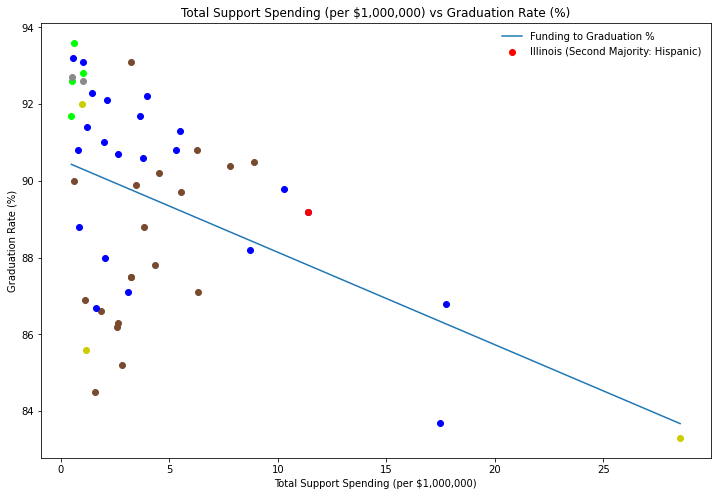

-2.408017281227087e-07x + 90.54886532051333

In [43]:
spending_with_lines_and_race(graduation_spending_df, "Total Support Spending", "High School Graduation Rate", x_scale=1_000_000, color=race_population_data["Second Biggest Race"], special=special, remove=["United States", "District of Columbia"], save="total_support_spending_vs_grad_rate_w_line_by_race.png", loc="upper right")

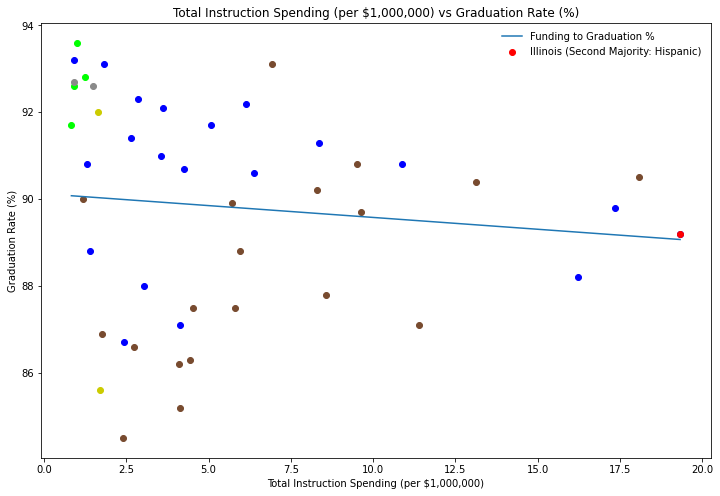

-5.44722228225818e-08x + 90.12248535764242

In [44]:
spending_with_lines_and_race(graduation_spending_df, "Total Instruction Spending", "High School Graduation Rate", x_scale=1_000_000, color=race_population_data["Second Biggest Race"], special=special, remove=["United States", "District of Columbia", "New York", "Texas", "California"], save="total_support_spending_vs_grad_rate_w_line_by_race.png", loc="upper right")

#### Graduation Rate per State by Race

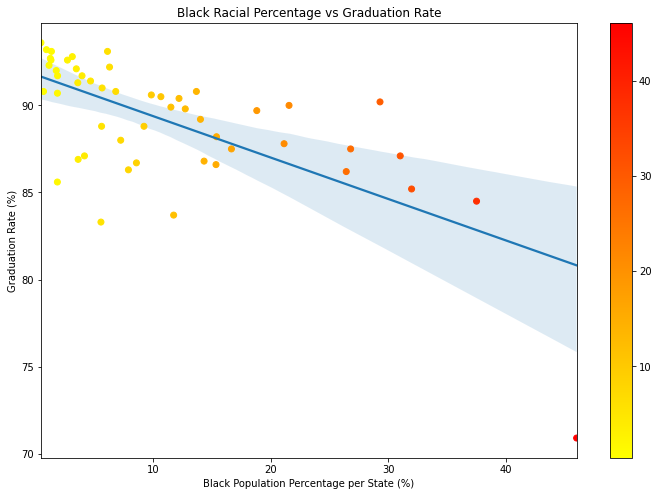

'-0.2374x + 91.7519'

In [45]:
def racial_percentage_plot(df:pd.DataFrame, race:str, save="", transparent=True, cmap="autumn_r", remove=()):
    label = ""
    if remove:
        label = f"Without: {', '.join(remove)}".rstrip(" ")
        for i in remove:
            df = df.drop(i)
    x = df.apply(lambda row : row[f"{race} Population"]/(row["Black Population"]+row["Hispanic Population"]+row["Native American Population"]+row["Asian Population"]+row["Pacific Islander Population"]+row["White Population"]+row["Other Population"]), axis=1)
    x = x.to_numpy() * 100
    y = df["Graduation Rate"].to_numpy()
    
    plt.figure(figsize=figsize)
    regplot(x=x, y=y, scatter=False, label=label) #Scatter is true if the points need shadows
    
    plt.title(race.title() + " Racial Percentage vs Graduation Rate")
    plt.xlabel(f"{race.title()} Population Percentage per State (%)")
    plt.ylabel("Graduation Rate (%)")
    if label:
        plt.legend(fancybox=True, framealpha=0)
    
    plt.scatter(x, y, c=x, cmap=cmap)
    plt.colorbar()
    plt.savefig(f"{output_folder}/education/{save}", transparent=transparent)
    plt.show()
    
    slope, intercept, _, _, _ = linregress(x, y)
    return f"{slope:.4f}x + {intercept:.4f}"
    
racial_percentage_plot(state_education_data, "Black", save="black_percentage_vs_grad_rate.png")

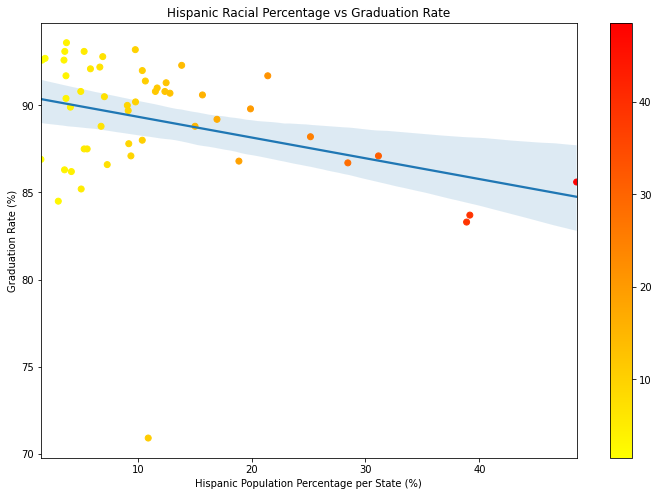

'-0.1193x + 90.5414'

In [46]:
racial_percentage_plot(state_education_data, "Hispanic", save="hispanic_percentage_vs_grad_rate.png")

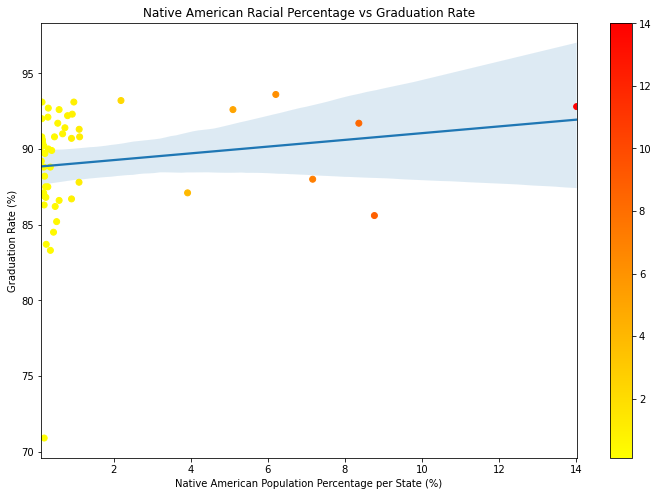

'0.2224x + 88.8203'

In [47]:
racial_percentage_plot(state_education_data, "Native American", save="native_american_percentage_vs_grad_rate.png")

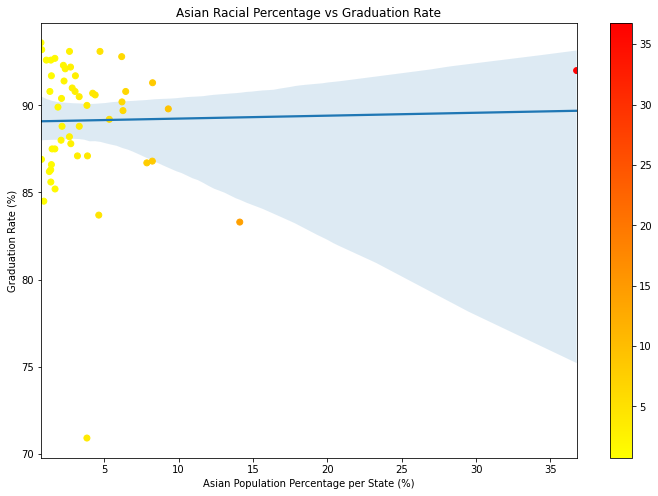

'0.0168x + 89.0741'

In [48]:
racial_percentage_plot(state_education_data, "Asian", save="asian_percentage_vs_grad_rate.png")

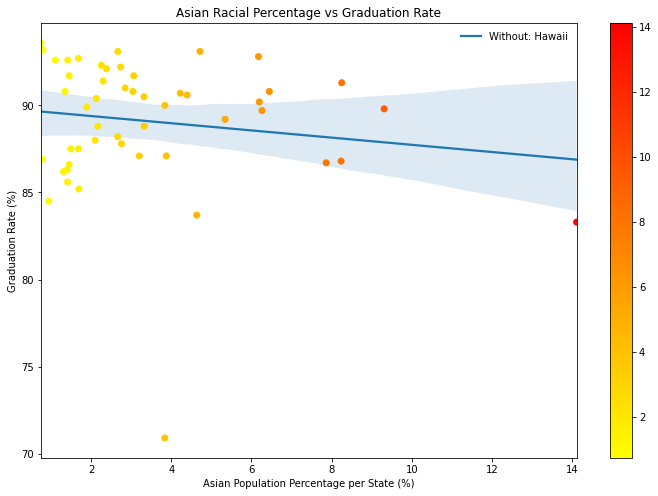

'-0.2066x + 89.8025'

In [49]:
racial_percentage_plot(state_education_data, "Asian", remove=["Hawaii"], save="asian_percentage_vs_grad_rate_w-o_hawaii.png")

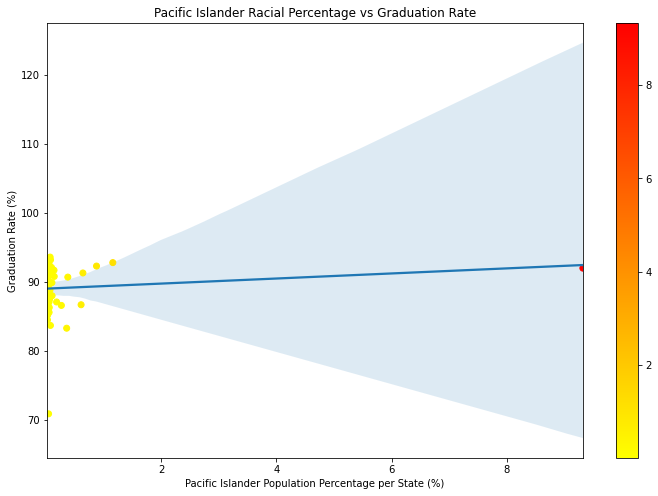

'0.3669x + 89.0295'

In [50]:
racial_percentage_plot(state_education_data, "Pacific Islander", save="pacific_islander_percentage_vs_grad_rate.png")

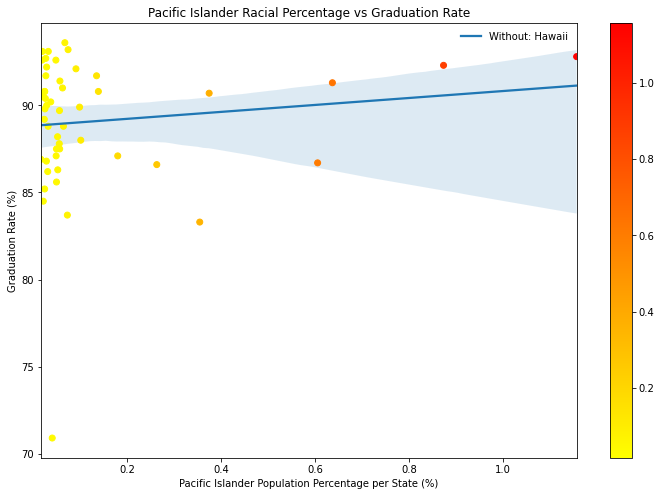

'1.9957x + 88.8277'

In [51]:
racial_percentage_plot(state_education_data, "Pacific Islander", remove=["Hawaii"], save="pacific_islander_percentage_vs_grad_rate_w-o_hawaii.png")

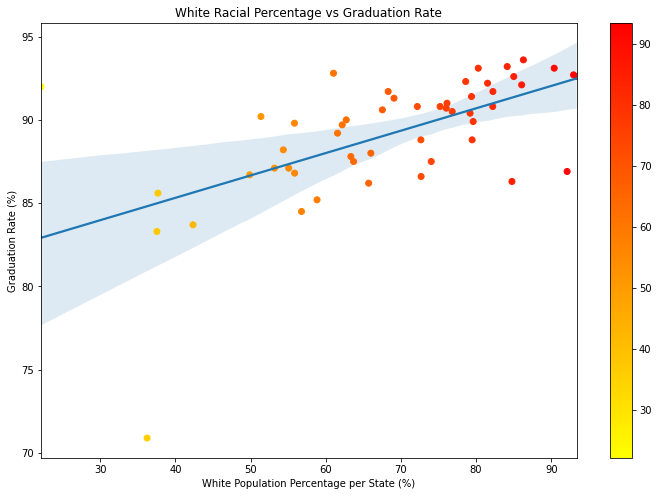

'0.1343x + 79.9456'

In [52]:
racial_percentage_plot(state_education_data, "White", save="white_percentage_vs_grad_rate.png")

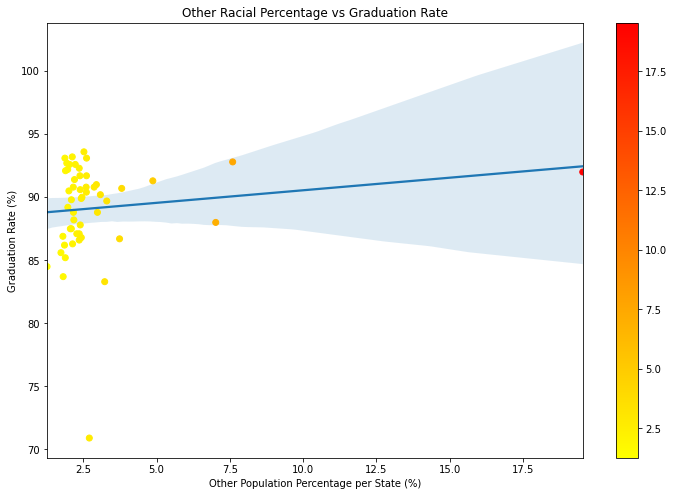

'0.1993x + 88.5572'

In [53]:
racial_percentage_plot(state_education_data, "Other", save="other_percentage_vs_grad_rate.png")

### Health

In [54]:
from causes import Causes
causes = Causes.from_csv(add_data_dir("Health/leading_causes_of_death.csv"))
causes.style.applymap(lambda x: 'white-space:wrap')
causes.head()

,Rank,Non-Blacks,All Blacks,Black Females,Black Males
0,Deaths,10109,9555,4593,4962
1,1,Heart disease 24.6%,Heart disease 23.9%,Heart disease 23.2%,Heart disease 24.4%
2,2,Cancer 22.2%,Cancer 20.9%,Cancer 22.4%,Cancer 19.5%
3,3,Accidents 6.0%,Accidents 6.7%,Stroke 7.7%,Homicide 9.3%
4,4,Stroke 5.9%,Stroke 6.1%,Accidents 4.0%,Accidents 9.2%


#### Life Expectancy

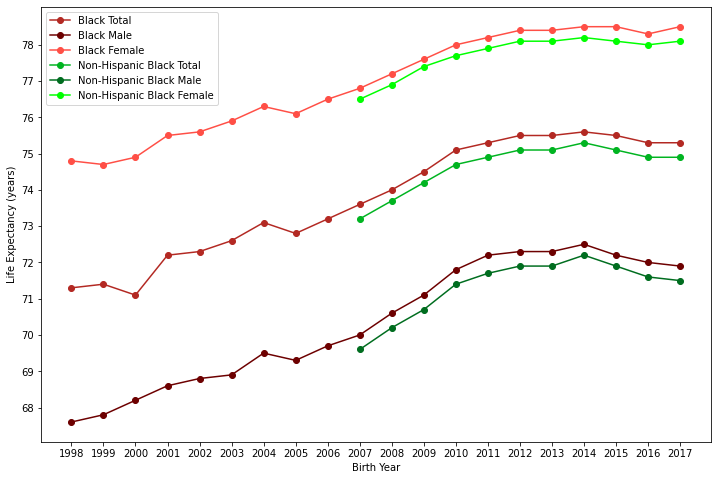

In [55]:
life_expectancy = LifeExpectancy(add_data_dir("Health/life_expectancy.csv"))

def expectancy(expectancy:LifeExpectancy, races:list, color_change=32, marker="o", save=""):
    colors = [["#6d0000", "#b32923", "#ff4f46"], ["#006d1f", "#00b421", "#00ff00"], ["#004c6d", "#00a1c1", "#00ffff"],
              ["#520f6d", "#a44ab4", "#ff87ff"], ["#6d6000", "#b3a000", "#fee500"]]
    
    plt.figure(figsize=figsize)
    mins, maxes = [], []
    for race, color in zip(races, colors[:len(races)]):
        table = expectancy[race]
        total = color[1]
        male = color[0]
        female = color[2]
        plt.plot(table.index, table["Total"], c=total, label=f"{race} Total", marker=marker)
        plt.plot(table.index, table["Male"], c=male, label=f"{race} Male", marker=marker)
        plt.plot(table.index, table["Female"], c=female, label=f"{race} Female", marker=marker)
 
        mins.append(min(min(table["Total"]), min(table["Male"]), min(table["Female"])))
        maxes.append(max(max(table["Total"]), max(table["Male"]), max(table["Female"])))
        
    plt.legend()
    plt.ylabel("Life Expectancy (years)")
    plt.xlabel("Birth Year")
    plt.yticks(np.arange(int(min(mins)), int(max(maxes)))+1)
    if save:
        plt.savefig(f"{output_folder}/health/{save}", transparent=True)
    plt.show()
    
expectancy(life_expectancy, ["Black", "Non-Hispanic Black"], save="us_life_expectancy.png")

#### Mortality Rates

### Police

In [56]:
state_police_shooting_data.head() #Decided to search for my zipcode when I updated MPV xlsx on 3/3, and I was scared that it came up. 60653. I've been born and raised here, and I was scared that there was a shooting here. I looked at the address. It is less than 2 blocks from my house. I could leave out now and be there in 3 minutes.

,State,State Abbreviation,Total Population,Black Population,Hispanic Population,Native American Population,Asian Population,Pacific Islander Population,White Population,Other Population,...,Rate (White People),Rate (All People),Disparity in Rate,Black-White Disparity,Hispanic-White Disparity,Native American-White Disparity,Allegedly Armed People Killed by Police (1/1/2013-12/31/2020),Unarmed/Did Not Have an Actual Weapon People Killed by Police (1/1/2013-12/31/2020),Unclear Armed Status People Killed by Police (1/1/2013-12/31/2020),People Armed with Vehicle Killed by Police (1/1/2013-12/31/2020)
0,Alaska,AK,738516.0,22817.0,51186.0,103506.0,45617.0,8544.0,450754.0,56092.0,...,6.655515,8.293659,2.642198,3.292530,0.366925,2.177429,38.0,3.0,6.0,2.0
1,Alabama,AL,4864680.0,1285737.0,203146.0,23243.0,63936.0,1521.0,3196730.0,90367.0,...,3.284606,4.059876,1.412853,1.746331,0.187335,0.000000,104.0,23.0,19.0,12.0
2,Arkansas,AR,2990671.0,458536.0,219052.0,17342.0,43441.0,7877.0,2173849.0,70574.0,...,3.852613,4.890207,1.951090,2.476562,0.444353,0.000000,89.0,10.0,8.0,10.0
3,Arizona,AZ,6946685.0,286614.0,2163312.0,271946.0,222477.0,12523.0,3825886.0,163927.0,...,5.194875,7.053724,2.040366,2.770457,1.546075,1.327222,289.0,56.0,27.0,20.0
4,California,CA,39148760.0,2164519.0,15221577.0,138427.0,5525439.0,138911.0,14695836.0,1264051.0,...,3.130138,4.304095,2.737139,3.763702,1.416709,2.307893,889.0,233.0,144.0,82.0


In [57]:
for i in state_police_shooting_data:
    print(i)

State
State Abbreviation
Total Population
Black Population
Hispanic Population
Native American Population
Asian Population
Pacific Islander Population
White Population
Other Population
% African-American
% Victims Black
Disparity
# Black people killed
# Hispanic people killed
# Native American people killed
# Asian people killed
# Pacific Islanders killed
# White people killed
# Unknown Race people killed
# People Killed
Rate (Black People)
Rate (Hispanic People)
Rate (Native American People)
Rate (Asian People)
Rate (Pacific Islanders)
Rate (White People)
Rate (All People)
Disparity in Rate
Black-White Disparity
Hispanic-White Disparity
Native American-White Disparity
Allegedly Armed People Killed by Police (1/1/2013-12/31/2020)
Unarmed/Did Not Have an Actual Weapon People Killed by Police (1/1/2013-12/31/2020)
Unclear Armed Status People Killed by Police (1/1/2013-12/31/2020)
People Armed with Vehicle Killed by Police (1/1/2013-12/31/2020)


In [58]:
drops = ["URL of image of victim", "A brief description of the circumstances surrounding the death", "Official disposition of death (justified or other)", "Link to news article or photo of official document", "Geography (via Trulia methodology based on zipcode population density: http://jedkolko.com/wp-content/uploads/2015/05/full-ZCTA-urban-suburban-rural-classification.xlsx )", "Fatal Encounters ID", "Encounter Type (DRAFT)", "Initial Reported Reason for Encounter (DRAFT)", "Names of Officers Involved (DRAFT)", "Race of Officers Involved (DRAFT)", "Known Past Shootings of Officer(s) (DRAFT)", "Alleged Weapon (Source: WaPo and Review of Cases Not Included in WaPo Database)", "Alleged Threat Level (Source: WaPo)", "MPV ID", "WaPo ID (If included in WaPo database)"]
drops

['URL of image of victim',
 'A brief description of the circumstances surrounding the death',
 'Official disposition of death (justified or other)',
 'Link to news article or photo of official document',
 'Geography (via Trulia methodology based on zipcode population density: http://jedkolko.com/wp-content/uploads/2015/05/full-ZCTA-urban-suburban-rural-classification.xlsx )',
 'Fatal Encounters ID',
 'Encounter Type (DRAFT)',
 'Initial Reported Reason for Encounter (DRAFT)',
 'Names of Officers Involved (DRAFT)',
 'Race of Officers Involved (DRAFT)',
 'Known Past Shootings of Officer(s) (DRAFT)',
 'Alleged Weapon (Source: WaPo and Review of Cases Not Included in WaPo Database)',
 'Alleged Threat Level (Source: WaPo)',
 'MPV ID',
 'WaPo ID (If included in WaPo database)']

In [59]:
police_killings_2013_2020 = pd.read_excel(add_data_dir("Police/MPVDatasetDownload.xlsx"), sheet_name="2013-2020 Police Killings")

def map_to_boolean(df:pd.DataFrame, columns:list):
    for string in columns:
        df[string] = df[string].replace({"Yes": True, "No": False, "yes": True, "no": False})

def convert_to_int(df:pd.DataFrame, columns:list):
    for string in columns:
        df[string] = df[string].convert_dtypes(convert_integer=True)

        
police_killings_2013_2020 = police_killings_2013_2020.drop(drops, axis=1)
police_killings_2013_2020["Victim's race"] = police_killings_2013_2020["Victim's race"].replace(np.NaN, "Unknown Race")
convert_to_int(police_killings_2013_2020, ["Zipcode"])
map_to_boolean(police_killings_2013_2020, ["Call for Service? (DRAFT)", "Symptoms of mental illness?", "Body Camera (Source: WaPo)"])
police_killings_2013_2020.columns = ["Victim's name", "Victim's age", "Victim's gender", "Victim's race",
        "Date of Incident", "Street Address of Incident", "City", "State", "Zipcode", "County",
        "Agency Responsible for Death", "ORI Agency Identifier", "Cause of death", "Criminal Charges",
        "Symptoms of mental illness", "Armed/Unarmed Status", "Fleeing", "Body Camera", "Off-Duty Killing", "Call for Service"]

police_killings_2013_2020.head()

,Victim's name,Victim's age,Victim's gender,Victim's race,Date of Incident,Street Address of Incident,City,State,Zipcode,County,Agency Responsible for Death,ORI Agency Identifier,Cause of death,Criminal Charges,Symptoms of mental illness,Armed/Unarmed Status,Fleeing,Body Camera,Off-Duty Killing,Call for Service
0,Name withheld by police,Unknown,Male,Unknown Race,2021-08-04,Glendora Avenue and Route 66,Glendora,CA,91741,Los Angeles,Azusa Police Department,CA0190500,Gunshot,No known charges,False,Allegedly Armed,Not Fleeing,False,False,True
1,Name withheld by police,Unknown,Male,Unknown Race,2021-08-04,3340 Peterson Road,Mifflin Township,OH,44903,Richland,Richland County Sheriff's Office,OH0700000,Gunshot,No known charges,False,Allegedly Armed,Not Fleeing,False,False,False
2,Antonio King,22,Male,Unknown Race,2021-08-03,NaN,Nashville,TN,<NA>,Davidson,Nashville Police Department,TN0190100,Gunshot,No known charges,Unknown,Allegedly Armed,Not Fleeing,False,False,True
3,Ent Wright,76,Male,Unknown Race,2021-08-03,701 Rambler Drive,Waco,TX,76710,McLennan,Waco Police Department,TX1551200,Gunshot,No known charges,False,Allegedly Armed,Not Fleeing,False,False,True
4,Name withheld by police,22,Male,Unknown Race,2021-08-03,1300 Fayette Street,Conshohocken,PA,19428,Montgomery,Conshohocken Police Department,PA0460700,Gunshot,No known charges,False,Allegedly Armed,Not Fleeing,False,False,True


In [60]:
police_killings_2013_2020["Victim's race"].unique()

array(['Unknown Race', 'Hispanic', 'Black', 'White', 'Asian',
       'Pacific Islander', 'Native American'], dtype=object)

#### Percentage of Race vs Percentage of Shootings

In [61]:
def get_shooting_percentages(df:pd.DataFrame, lis:list) -> list:
    return [100 * len(df["Victim's race"][df["Victim's race"] == race]) / len(df["Victim's race"]) for race in lis]
    

race_percentages_in_america = {"Unknown Race": 6.2, "Hispanic": 16.3, "White": 72.4, "Black": 12.6, "Native American": .9, "Pacific Islander": .2, "Asian": 4.8} # https://www.cia.gov/the-world-factbook/countries/united-states/#people-and-society
police_killings_percentage = pd.DataFrame({"Race": [i for i in race_percentages_in_america.keys()]})
police_killings_percentage["Percentage of America"] = [i for i in race_percentages_in_america.values()]
police_killings_percentage["Percentage in Shootings"] = get_shooting_percentages(police_killings_2013_2020, race_percentages_in_america.keys())
police_killings_percentage["Ratio of Shootings in America"] = police_killings_percentage.apply(lambda row: row["Percentage in Shootings"] / row["Percentage of America"], axis=1)
police_killings_percentage.head(len(police_killings_percentage))

,Race,Percentage of America,Percentage in Shootings,Ratio of Shootings in America
0,Unknown Race,6.2,10.414894,1.679822
1,Hispanic,16.3,17.765957,1.089936
2,White,72.4,43.393617,0.599359
3,Black,12.6,25.000000,1.984127
4,Native American,0.9,1.393617,1.548463
5,Pacific Islander,0.2,0.563830,2.819149
6,Asian,4.8,1.468085,0.305851


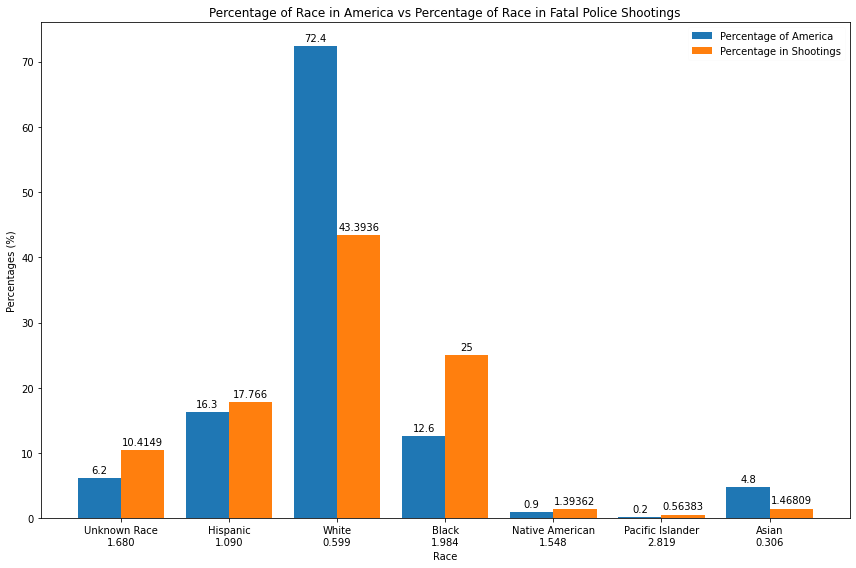

In [62]:
def get_x_ticks(df:pd.DataFrame) -> tuple:
    lis = []
    for i in range(len(df["Race"])):
        row = df.loc[i]
        lis.append("{}\n{:.3f}".format(row["Race"], row["Ratio of Shootings in America"]))
    return tuple(lis)

x = np.arange(len(race_percentages_in_america))
width = 0.4

fig, ax = plt.subplots(figsize=figsize)
population_rectangle = ax.bar(x - width/2, police_killings_percentage["Percentage of America"], width, label="Percentage of America")
shooting_rectangle = ax.bar(x + width/2, police_killings_percentage["Percentage in Shootings"], width, label="Percentage in Shootings")

ax.set_ylabel("Percentages (%)")
ax.set_xlabel("Race")
ax.set_title("Percentage of Race in America vs Percentage of Race in Fatal Police Shootings")
ax.set_xticks(x)
ax.set_xticklabels(get_x_ticks(police_killings_percentage))
ax.legend(fancybox=True, framealpha=0.05)

padding=3
ax.bar_label(population_rectangle, padding=padding)
ax.bar_label(shooting_rectangle, padding=padding)

fig.tight_layout()

plt.savefig(f"{output_folder}/police/police_shootings_percent_vs_population_percent.png", transparent=True)
plt.show()

#### Statistics and Pie Charts

In [63]:
police_killings_percentage.head(len(police_killings_percentage))

,Race,Percentage of America,Percentage in Shootings,Ratio of Shootings in America
0,Unknown Race,6.2,10.414894,1.679822
1,Hispanic,16.3,17.765957,1.089936
2,White,72.4,43.393617,0.599359
3,Black,12.6,25.000000,1.984127
4,Native American,0.9,1.393617,1.548463
5,Pacific Islander,0.2,0.563830,2.819149
6,Asian,4.8,1.468085,0.305851


In [64]:
police_killings_percentage.columns

Index(['Race', 'Percentage of America', 'Percentage in Shootings',
       'Ratio of Shootings in America'],
      dtype='object')

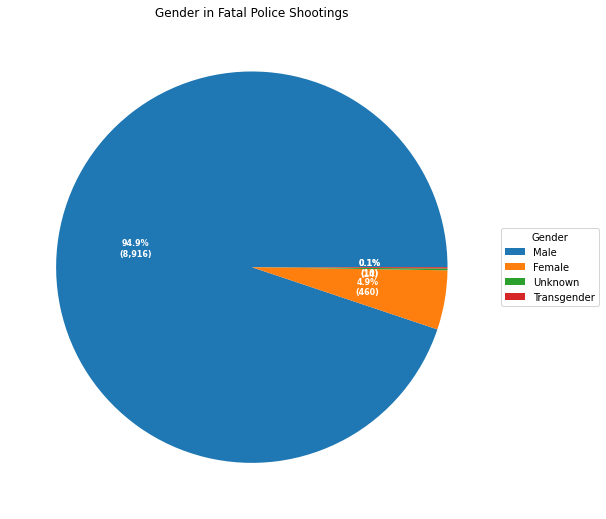

In [65]:
def crop(file:str):
    im = Image.open(file).convert("RGBA")
    im.crop(im.getbbox()).save(file)

def _point_text(pct, data, series):
        absolute = int(round(pct/100.*np.sum([len(series[series==list(i.keys())[0]]) for i in data]))) 
        return "{:.1f}%\n({:,d})".format(pct, absolute)
    
def pie_chart(series, title, save="", cropping=True, transparent=True, focus=(), other="Other", split_on_comma=False, warning=False):
    series = series.replace(np.nan, "No Info")
    
    if focus:
        focus += ["No Info"]
        for i in range(len(series)):
            if series.loc[i] not in focus:
                series.loc[i] = other
    fig, ax = plt.subplots(figsize=(18, 9), subplot_kw=dict(aspect="equal"))
    
    if split_on_comma:
        warning = True
        data = [{i: len(series[i in series])/len(series)} for i in series.unique()] #The key is the unique value, the key is the percent of the time
    else:
        data = [{i: len(series[i == series])/len(series)} for i in series.unique()]
    
    wedges, texts, autotexts = ax.pie([list(i.values())[0] for i in data], autopct=lambda point: _point_text(point, data, series), textprops=dict(color="w"))
    ax.legend(wedges, series.unique(),
              title=title,
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))

    plt.setp(autotexts, size=8, weight="bold")

    ax.set_title(f"{title.replace(':', '')} in Fatal Police Shootings")
    
    if warning:
        ax.text(1, -1, "Note: Percents add up to over 100% because of multiple categories applying", style="italic", fontsize=9)
    
    if save:
        plt.savefig(f"{output_folder}/police/{save}", transparent=transparent)
        if cropping:
            crop(f"{output_folder}/police/{save}")
    plt.show()

pie_chart(police_killings_2013_2020["Victim's gender"], "Gender", save="gender.png", cropping=True, warning=False)

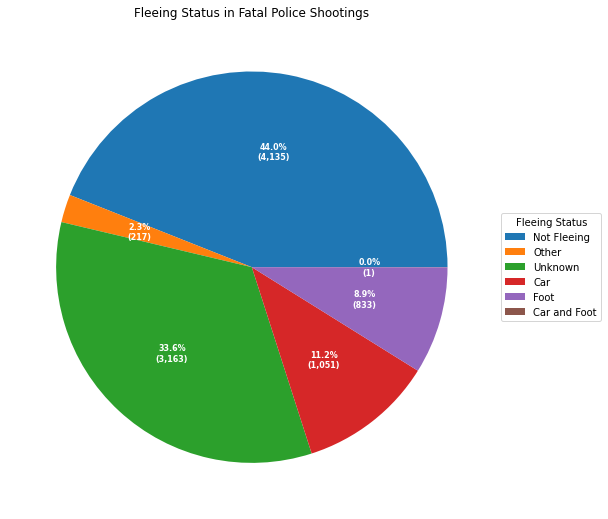

In [66]:
pie_chart(police_killings_2013_2020["Fleeing"], "Fleeing Status", save="fleeing.png", cropping=True)

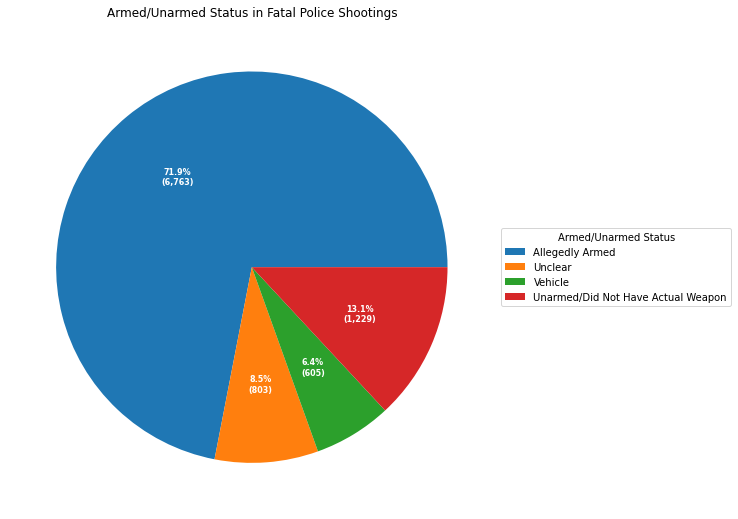

In [67]:
pie_chart(police_killings_2013_2020["Armed/Unarmed Status"], "Armed/Unarmed Status", save="armed.png", cropping=True)

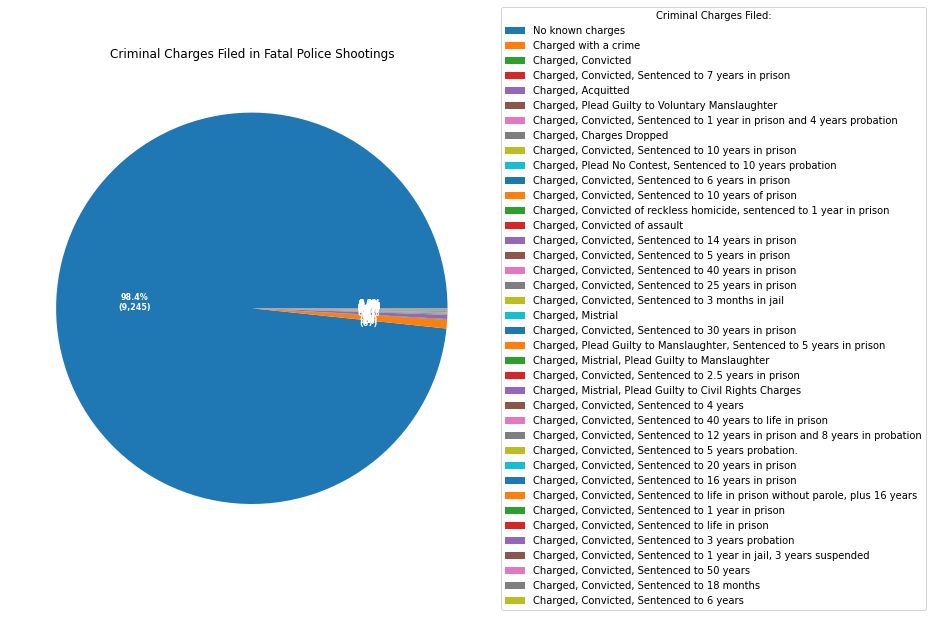

In [68]:
pie_chart(police_killings_2013_2020["Criminal Charges"], "Criminal Charges Filed:", save="charges.png", cropping=True)

In [69]:
#test = police_killings_2013_2020["Sentenced" in police_killings_2013_2020["Criminal Charges"]]
#test.head(len(test))

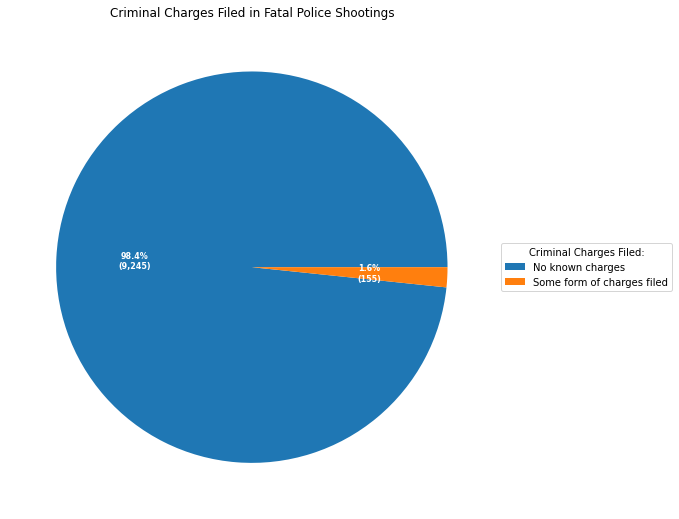

In [70]:
pie_chart(police_killings_2013_2020["Criminal Charges"], "Criminal Charges Filed:", save="charges_specified.png", cropping=True, focus=["No known charges"], other="Some form of charges filed")

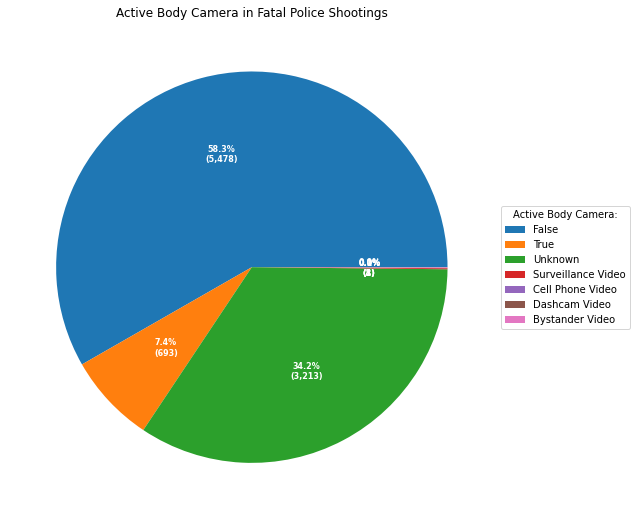

In [71]:
pie_chart(police_killings_2013_2020["Body Camera"], "Active Body Camera:", save="body_camera.png", cropping=True)

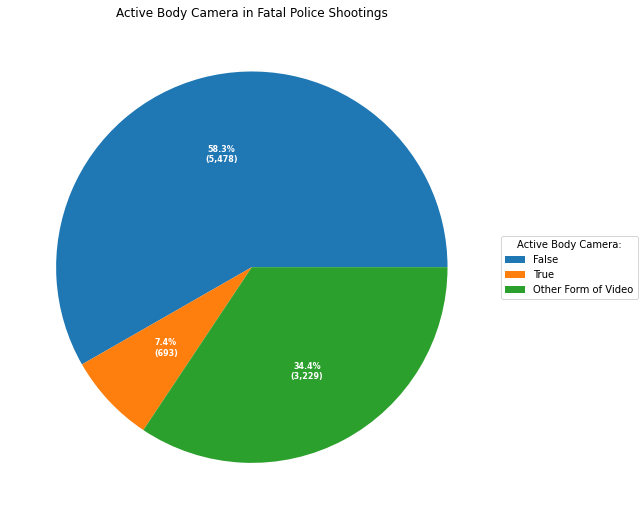

In [72]:
pie_chart(police_killings_2013_2020["Body Camera"], "Active Body Camera:", save="body_camera_specified.png", cropping=True, focus=[True, False], other="Other Form of Video")

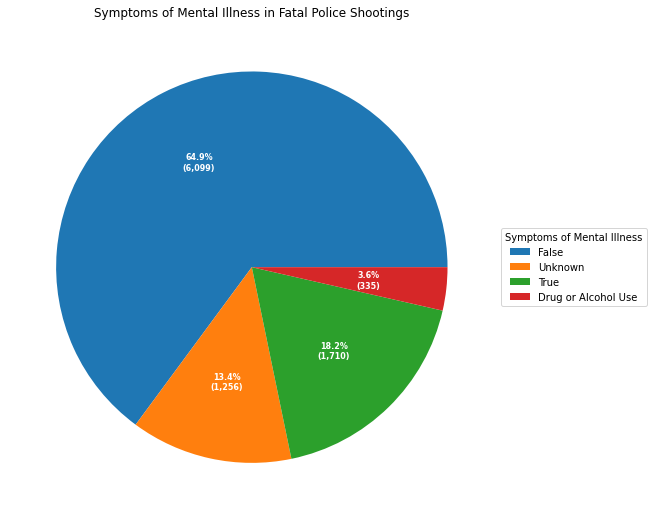

In [73]:
pie_chart(police_killings_2013_2020["Symptoms of mental illness"], "Symptoms of Mental Illness", save="mental_illness.png", cropping=True)

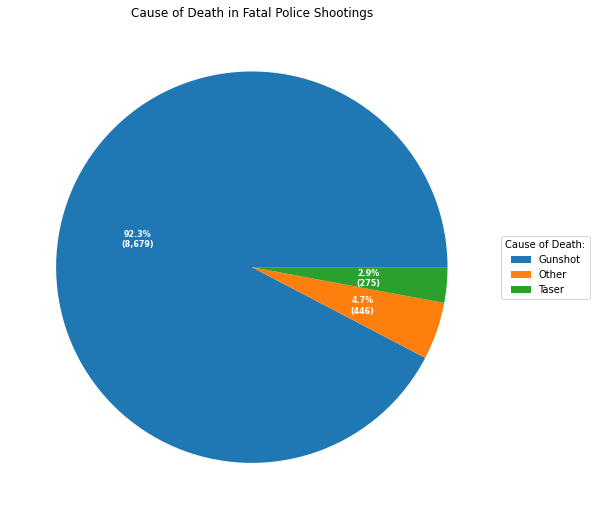

In [74]:
pie_chart(police_killings_2013_2020["Cause of death"], "Cause of Death:", save="cause_of_death.png", cropping=True, focus=["Gunshot", "Taser"])

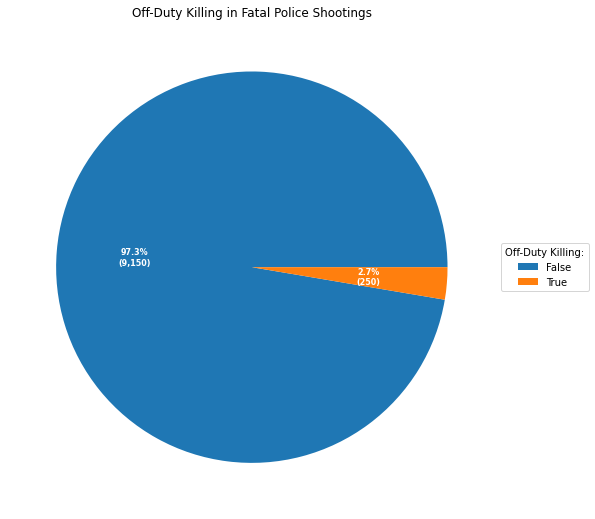

In [75]:
pie_chart(police_killings_2013_2020["Off-Duty Killing"], "Off-Duty Killing:", save="off_duty_killing.png", cropping=True)

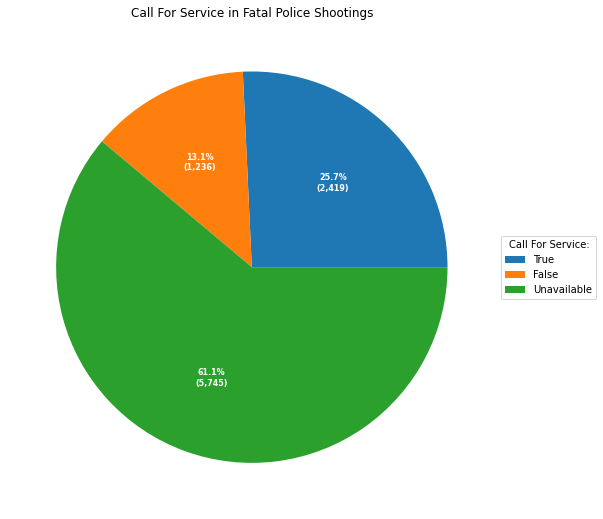

In [76]:
pie_chart(police_killings_2013_2020["Call for Service"], "Call For Service:", save="call_for_service.png", cropping=True)

In [77]:
#pie_chart(police_killings_2013_2020["Cause of death"], "Cause of Death:", save="cause_of_death.png", cropping=True, split_on_comma=True)

#### Convictions vs Race

In [78]:
charged = police_killings_2013_2020["No known charges" != police_killings_2013_2020["Criminal Charges"]]
charged.head()

,Victim's name,Victim's age,Victim's gender,Victim's race,Date of Incident,Street Address of Incident,City,State,Zipcode,County,Agency Responsible for Death,ORI Agency Identifier,Cause of death,Criminal Charges,Symptoms of mental illness,Armed/Unarmed Status,Fleeing,Body Camera,Off-Duty Killing,Call for Service
327,Daunte Wright,20,Male,Black,2021-04-11,6300 Orchard Ave.,Brooklyn Center,MN,55429,Hennepin,Brooklyn Center Police Department,MN0270200,Gunshot,Charged with a crime,False,Unarmed/Did Not Have Actual Weapon,Not Fleeing,True,False,False
341,James Lionel Johnson,38,Male,Black,2021-04-07,7333 New Hampshire Avenue,Takoma Park,MD,20912,Montgomery,U.S. Pentagon Force Protection Agency,U.S. Pentagon Force Protection Agency,Gunshot,Charged with a crime,False,Unclear,Unknown,Unknown,True,False
342,Dominique Williams,32,Male,Black,2021-04-07,7333 New Hampshire Avenue,Takoma Park,MD,20912,Montgomery,U.S. Pentagon Force Protection Agency,US Pentagon Force Protection Agency,Gunshot,Charged with a crime,False,Unclear,Unknown,Unknown,True,False
349,Iremamber Sykap,16,Male,Pacific Islander,2021-04-05,Kalakaua Avenue and Philip Street,Honolulu,HI,96826,Honolulu,Honolulu Police Department,HI0020000,Gunshot,Charged with a crime,False,Unclear,Other,False,False,False
620,"Robert ""Lil Rob"" Howard",30,Male,Black,2021-01-06,Frayser Boulevard and Denver Street,Memphis,TN,38127,Shelby,Memphis Police Department,TNMPD0000,Gunshot,Charged with a crime,False,Unclear,Unknown,Unknown,False,False


In [79]:
def get_charging_rates(df:pd.DataFrame, race:str, column="Victim's race", pretty_str=True):
    rate = len(df[df[column] == race]) / len(police_killings_2013_2020[column])
    if pretty_str:
        return f"The rate that the officers who killed {race} people were charged is {rate*100:#.4f}%"
    return rate

print(get_charging_rates(charged, "Black"))

The rate that the officers who killed Black people were charged is 0.8085%


In [80]:
black = charged[charged["Victim's race"] == "Black"]
len([i for i in black["Criminal Charges"] if "Convicted" in i])

18

In [81]:
tmp_list = list(police_killings_2013_2020.City.unique())
for i in range(len(tmp_list)):
    for j in range(i+1, len(tmp_list)):
        if not (isinstance(tmp_list[i], float) or isinstance(tmp_list[j], float)):
            if tmp_list[i].lower() == tmp_list[j].lower():
                print(i, j)

In [82]:
other_killed = len(police_killings_2013_2020[police_killings_2013_2020["Victim's race"] != "Black"])
other_killed

7050

#### Statistically Signifigant Shootings

In [83]:
def is_statistically_signifigant(race:str, df:pd.DataFrame, alpha=.05, alternative="larger") -> bool:
    race_killed = len(df[df["Victim's race"] == race])
    other_killed = len(df[df["Victim's race"] != race])
    us_population = 331_449_281
    race_length = (police_killings_percentage[police_killings_percentage.Race == race]["Percentage of America"] * us_population / 100).values[0]
    other_length = us_population - race_length
    race_prop = race_killed / race_length
    other_prop = other_killed / other_length
    print(race, race_killed, race_length)
    zscore, pval = proportions_ztest(np.array([race_killed, other_killed]), np.array([race_length, other_length]), alternative=alternative)
    return alpha > pval, zscore, pval

is_statistically_signifigant("Black", police_killings_2013_2020)

Black 2350 41762609.405999996


(True, 36.22853575331211, 1.0821763991709599e-287)

In [84]:
for race in police_killings_2013_2020["Victim's race"].unique():
    stat_sig, zscore, pval = is_statistically_signifigant(race, police_killings_2013_2020)
    #print(f"The killings of {race} people by Police is {'not ' if not stat_sig else ''}statistically signifigant with a Z-value of {zscore:#.4f} and a p-value of {pval:#.4f}.")

Unknown Race 979 20549855.422000002
Hispanic 1670 54026232.803
Black 2350 41762609.405999996
White 4079 239969279.444
Asian 138 15909565.488
Pacific Islander 53 662898.562
Native American 131 2983043.5290000006


### Prison

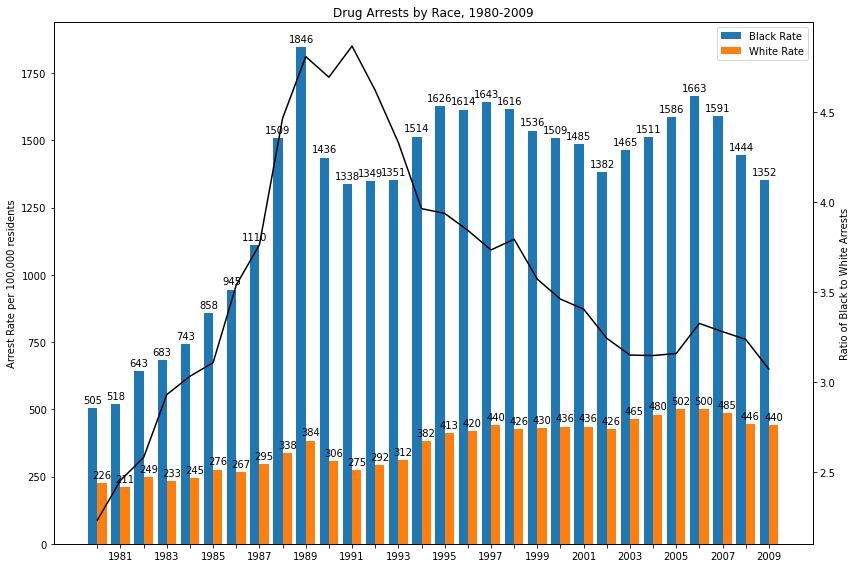

In [85]:
table2 = pd.read_csv(add_data_dir("Police/oxford_race_drugs_report/table2.csv"))

x = np.arange(len(table2))
width = 0.4

fig, ax = plt.subplots(figsize=figsize)
black_rectangle = ax.bar(x - width/2, table2["Black Rate"], width, label="Black Rate")
white_rectangle = ax.bar(x + width/2, table2["White Rate"], width, label="White Rate")

ax.set_ylabel("Arrest Rate per 100,000 residents")
ax.set_title("Drug Arrests by Race, 1980-2009")
ax.set_xticks(x)
ax.set_xticklabels([i if i % 2 == 1 else "" for i in x+1980])
ax.legend(fancybox=True, framealpha=0.05)

padding=3
ax.bar_label(black_rectangle, padding=padding)
ax.bar_label(white_rectangle, padding=padding)

ax2 = table2["True Rate"].plot(secondary_y=True, c="#000000")
ax2.set_ylabel("Ratio of Black to White Arrests")

fig.tight_layout()

plt.savefig(f"{output_folder}/prison/table2.png", transparent=True)
plt.show()
del ax2

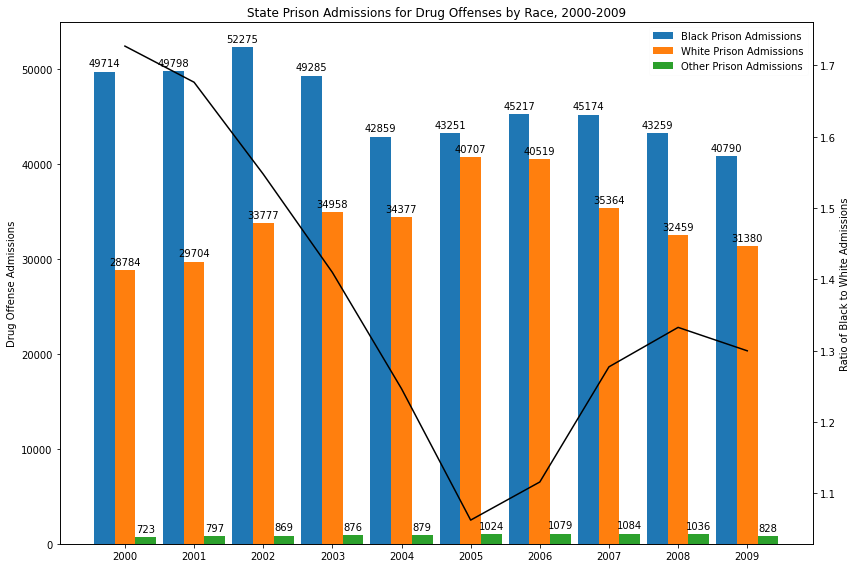

In [86]:
table3 = pd.read_csv(add_data_dir("Police/oxford_race_drugs_report\\table3.csv"))
table_2_3 = table2[table2["Year"].isin(np.arange(2000, 2010))].merge(table3, on="Year")

table_2_3 = table_2_3.set_index("Year")
table_2_3["Ratio of Black to White Admission"] = table_2_3.apply(lambda row: row["Black"]/row["White"], axis=1)  
                   
fig = plt.figure(figsize=figsize)
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
x = np.arange(len(table_2_3))
width = .3

black_rectangle = ax1.bar(x - width, table_2_3["Black"], width, label="Black Prison Admissions")
white_rectangle = ax1.bar(x, table_2_3["White"], width, label="White Prison Admissions")
other_rectangle = ax1.bar(x + width, table_2_3["Other*"], width, label="Other Prison Admissions")

ax1.set_ylabel("Drug Offense Admissions")
ax1.set_title("State Prison Admissions for Drug Offenses by Race, 2000-2009")
ax1.set_xticks(x)
ax1.set_xticklabels(table_2_3.index)
ax1.legend(fancybox=True, framealpha=0.05)

padding=3
ax1.bar_label(black_rectangle, padding=padding)
ax1.bar_label(white_rectangle, padding=padding)
ax1.bar_label(other_rectangle, padding=padding)

ax2.plot(x, table_2_3["Ratio of Black to White Admission"], color='#000')
ax2.set_ylabel("Ratio of Black to White Admissions")
fig.tight_layout()

plt.savefig(f"{output_folder}/prison/table3.png", transparent=True)
plt.show()

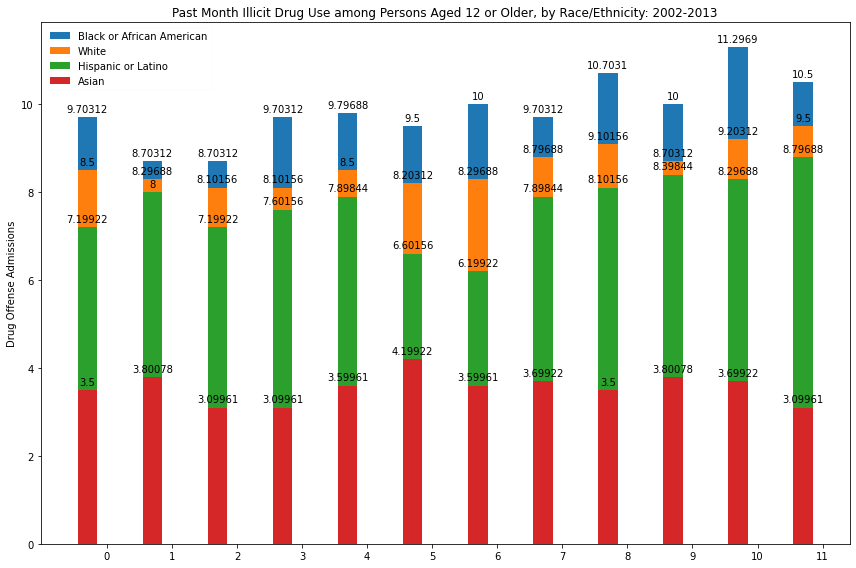

In [87]:
def stacked_inmates_grapher(inmates:Inmates, x:str, df="df", title="", save="", transparent=True):
    df = getattr(inmates, df)
    df = df.drop([x], axis=1)
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(111)
    x = np.arange(len(df))
    width = .3

    rectangles = []
    for column in df.columns:
        rectangles.append(ax1.bar(x - width, df[column], width, label=column))

    ax1.set_ylabel("Drug Offense Admissions")
    if hasattr(inmates, "title"):
        ax1.set_title(inmates.title)
    else:
        ax1.set_title(title)
    ax1.set_xticks(x)
    ax1.set_xticklabels(df.index)
    ax1.legend(fancybox=True, framealpha=0.05)

    padding=3
    for rectangle in rectangles:
        ax1.bar_label(rectangle, padding=padding)

    fig.tight_layout()

    if save:
        plt.savefig(f"{output_folder}/prison/{save}.png", transparent=transparent)
    plt.show()

stacked_inmates_grapher(Inmates(add_data_dir("Prison/racialdruguse.csv")), "Year", title="Past Month Illicit Drug Use among Persons Aged 12 or Older, by Race/Ethnicity: 2002-2013", save="stacked.png")

<Figure size 864x576 with 0 Axes>

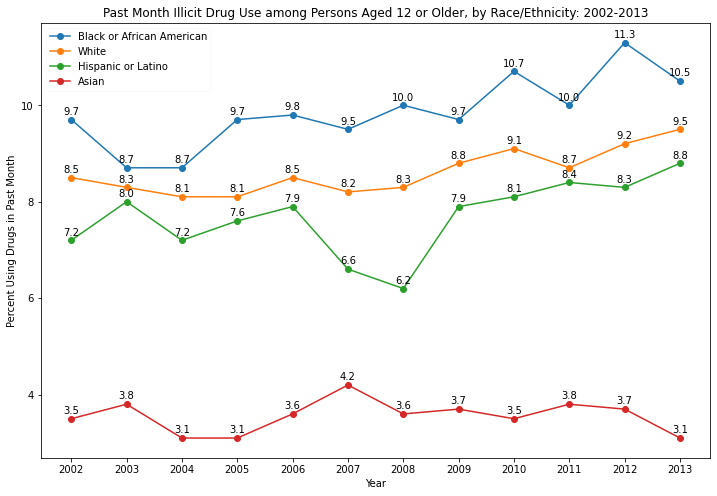

In [88]:
def inmates_grapher(inmates:Inmates, x="", df="df", title="", ylabel="", save="", transparent=True):
    df = getattr(inmates, df)
    fig = plt.figure(figsize=figsize)
    if hasattr(inmates, "title"):
        title = inmates.title
    if not x:
        x = df.index
    
    df[x] = df[x].astype(int)
    
    ax = df.plot(x=x,
                kind='line',
                stacked=False,
                title = title,
                figsize=figsize,
                ylabel=ylabel,
                marker='o')
    
    columns = list(df.columns)
    columns.remove(x)
    for column in columns:
        for x_value, y in zip(df[x], df[column]):
            label = f"{y:.1f}"
            plt.annotate(label, (int(x_value),y), textcoords="offset points", xytext=(0, 5), ha='center')
                
    fig.tight_layout()
    plt.legend(fancybox=True, framealpha=0.1)
    ax.set_xticks(df[x])
    if save:
        plt.savefig(f"{output_folder}/prison/{save}.png", transparent=transparent)
    plt.show()

inmates_grapher(Inmates(add_data_dir("Prison/racialdruguse.csv"), index=False), x="Year", ylabel="Percent Using Drugs in Past Month", title="Past Month Illicit Drug Use among Persons Aged 12 or Older, by Race/Ethnicity: 2002-2013", save="illicit_drug_use.png")

In [89]:
#inmates_grapher(Inmates(add_data_dir("Prison/jail_inmates_2018/ji18at01.csv"), index=False), df="race", ylabel="Percent Using Drugs in Past Month", title="Past Month Illicit Drug Use among Persons Aged 12 or Older, by Race/Ethnicity: 2002-2013", save="prison_estimated_population.png")

In [90]:
drug_sales_by_race = pd.read_csv(add_data_dir("Police/oxford_race_drugs_report/sales.csv")).set_index("Drug Type")
drug_sales_by_race.head()

,White,Black,Native American,Asian,Total
Drug Type,,,,,
Cocaine/Heroin,34787,45635,346,351,81119
Marijuana,50196,30210,582,838,81826
Other,60015,11369,480,703,72567
Total,144998,87214,1408,1892,235512


In [91]:
drug_possession_by_race = pd.read_csv(add_data_dir("Police/oxford_race_drugs_report/possession.csv")).set_index("Drug Type")
drug_possession_by_race.head()

,White,Black,Native American,Asian,Total
Drug Type,,,,,
Cocaine/Heroin,132466,74107,772,1410,208755
Marijuana,392127,187577,4806,4906,589416
Other,207809,41004,2009,2718,253540
Total,732402,302688,7587,9034,1051711


In [92]:
my_demographic = police_killings_2013_2020[police_killings_2013_2020["City"] == "Chicago"]
my_demographic = my_demographic[my_demographic["Victim's age"].replace("Unknown", 100) <= 21]
my_demographic = my_demographic[my_demographic["Victim's race"] == "Black"]

my_demographic.head(len(my_demographic))

,Victim's name,Victim's age,Victim's gender,Victim's race,Date of Incident,Street Address of Incident,City,State,Zipcode,County,Agency Responsible for Death,ORI Agency Identifier,Cause of death,Criminal Charges,Symptoms of mental illness,Armed/Unarmed Status,Fleeing,Body Camera,Off-Duty Killing,Call for Service
387,Travon Chadwell,18,Male,Black,2021-03-25,2400 West 46th St.,Chicago,IL,60632,Cook,Chicago Police Department,ILCPD0000,Gunshot,No known charges,False,Allegedly Armed,Car,Unknown,False,True
2429,Curtis Stagger,21,Male,Black,2019-05-28,8100 S Chappel Ave,Chicago,IL,60617,Cook,Chicago Police Department,ILCPD0000,Gunshot,No known charges,False,Allegedly Armed,Not Fleeing,False,False,False
2705,Michael Elam,20,Male,Black,2019-02-16,2100 S Keeler Ave,Chicago,IL,60623,Cook,Chicago Police Department,ILCPD0000,Gunshot,No known charges,False,Allegedly Armed,Car,False,False,False
2982,Sarge Junior,16,Male,Black,2018-11-22,5800 N Talman Ave,Chicago,IL,60659,Cook,Chicago Police Department,ILCPD0000,Gunshot,No known charges,False,Allegedly Armed,Unknown,Unknown,True,False
4627,Corsean Lewis,17,Male,Black,2017-06-02,5800 S Wabash Ave,Chicago,IL,60637,Cook,Chicago Police Department,ILCPD0000,Gunshot,No known charges,False,Allegedly Armed,Not Fleeing,False,False,Unavailable
4671,Rashad S. Wells Jr.,17,Male,Black,2017-05-17,132 W 69th St,Chicago,IL,60621,Cook,Cook County Sheriff's Office,IL0160000,Gunshot,No known charges,False,Allegedly Armed,Not Fleeing,Unknown,True,Unavailable
5031,Joshua D. Jones,20,Male,Black,2017-01-20,12300 South Wallace,Chicago,IL,60628,Cook,Robbins Police Department,IL0169700,Gunshot,No known charges,False,Allegedly Armed,Not Fleeing,Unknown,True,Unavailable
5200,Kajuan Raye,19,Male,Black,2016-11-23,6500 S. Marshfield Ave,Chicago,IL,60636,Cook,Chicago Police Department,ILCPD0000,Gunshot,No known charges,False,Unclear,Foot,False,False,Unavailable
5540,Paul O'Neal,18,Male,Black,2016-07-28,7300 S Merrill Ave,Chicago,IL,60649,Cook,Chicago Police Department,ILCPD0000,Gunshot,No known charges,False,Vehicle,Car,True,False,Unavailable
5853,Pierre Loury,16,Male,Black,2016-04-11,3400 West Grenshaw Street,Chicago,IL,60624,Cook,Chicago Police Department,ILCPD0000,Gunshot,No known charges,False,Allegedly Armed,Foot,False,False,Unavailable


In [93]:
len(my_demographic)

23

In [94]:
len(police_killings_2013_2020["Victim's name"])

9400